# **Segmentação de clientes**

In [636]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# pip install yellowbrick

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter
from datetime import datetime, timedelta

%matplotlib inline

In [637]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [638]:
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

## Carregamento de dados

In [639]:
df_vendas = pd.read_csv('data/TFVenda.csv')
df_clientes = pd.read_csv('data/DimCliente.csv')
df_produtos = pd.read_csv('data/DimProduto.csv')
df_tempo = pd.read_csv('data/DimTempo.csv')

In [640]:
df_vendas

,DataId,ClienteId,ProdutoId,Quantidade,PrecoUnitario,PercentagemDesconto,ValorTotal,Canal
0,2022-02-23,100,172,2,575.82,26.0,1151.63,Online
1,2022-06-02,102,166,4,95.18,7.0,380.70,Online
2,2022-04-29,103,135,3,284.75,10.0,854.24,Online
3,2023-09-14,103,25,3,495.92,42.0,1487.77,Online
4,2024-08-22,103,58,3,264.26,4.0,792.79,Online
...,...,...,...,...,...,...,...,...
3163,2025-02-23,2097,136,3,469.78,44.0,1409.33,Online
3164,2021-10-18,2099,7,3,94.29,36.0,282.87,Online
3165,2021-10-26,2099,86,2,35.56,1.0,71.12,Online
3166,2023-02-04,2099,174,2,687.68,29.0,1375.35,Online


In [641]:
df_clientes

,ClienteId,Nome,Sexo,EstadoCivil,Profissão,Concelho,Distrito,DataNascimento
0,100,Vicente de Sá,Masculino,Solteiro,Carpinteiro,Sabugal,Guarda,1988-08-31
1,101,Martim Paiva,Masculino,Casado,Engenheiro,Santa Maria da Feira,Aveiro,1988-08-20
2,102,Yasmin Henriques,Feminino,Divorciado,Estudante,Vizela,Braga,2006-08-09
3,103,Micael Almeida,Masculino,Casado,Contabilista,Sertã,Castelo Branco,2002-12-10
4,104,Nuno de Branco,Masculino,Solteiro,Gestor de Projetos,Porto,Porto,1954-01-08
...,...,...,...,...,...,...,...,...
1995,2095,Noa da Antunes,Masculino,Viúvo,Arquiteto,Estremoz,Évora,1956-07-31
1996,2096,Rodrigo Sá,Masculino,Casado,Rececionista,Celorico de Basto,Braga,1954-12-09
1997,2097,Soraia Fernandes,Feminino,Divorciado,Motorista,Amadora,Lisboa,1953-12-09
1998,2098,Brian Costa,Masculino,Casado,Programador,Valongo,Porto,1994-06-05


In [642]:
df_produtos

,ProdutoId,Nome,Marca,Categoria
0,1,Rato Logitech MX Master,Logitech,Perifericos
1,2,Logitech Rato MX Anywhere,Logitech,Perifericos
2,3,Teclado Mecânico Corsair K70,Corsair,Perifericos
3,4,Teclado Gaming Razer BlackWidow,Razer,Perifericos
4,5,"Monitor Dell 24"",Dell,Monitores\n6,Monitor 27 ...",HP,Monitores
...,...,...,...,...
168,171,Rato SteelSeries Rival 5,SteelSeries,Perifericos
169,172,Teclado Razer Pro Type,Razer,Perifericos
170,173,"Monitor 27 ASUS ProArt""",ASUS,Monitores
171,174,Headset Sennheiser HD 560S,Sennheiser,Audio


In [643]:
df_tempo

,DataId,Mes,Trimestre,Ano,FimDeSemana,Feriado
0,2010-01-15,1,1,2010,N,S
1,2010-01-20,1,1,2010,N,S
2,2010-01-25,1,1,2010,N,S
3,2010-01-27,1,1,2010,N,S
4,2010-02-18,2,1,2010,N,S
...,...,...,...,...,...,...
1572,2025-04-06,4,2,2025,S,S
1573,2025-04-07,4,2,2025,N,S
1574,2025-04-08,4,2,2025,N,S
1575,2025-04-09,4,2,2025,N,S


In [644]:
df_vendas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DataId               3168 non-null   object 
 1   ClienteId            3168 non-null   int64  
 2   ProdutoId            3168 non-null   int64  
 3   Quantidade           3168 non-null   int64  
 4   PrecoUnitario        3168 non-null   float64
 5   PercentagemDesconto  3168 non-null   float64
 6   ValorTotal           3168 non-null   float64
 7   Canal                3168 non-null   object 
dtypes: float64(3), int64(3), object(2)
memory usage: 198.1+ KB


In [645]:
df_clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ClienteId       2000 non-null   int64 
 1   Nome            2000 non-null   object
 2   Sexo            2000 non-null   object
 3   EstadoCivil     2000 non-null   object
 4   Profissão       2000 non-null   object
 5   Concelho        2000 non-null   object
 6   Distrito        2000 non-null   object
 7   DataNascimento  2000 non-null   object
dtypes: int64(1), object(7)
memory usage: 125.1+ KB


In [646]:
df_produtos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ProdutoId  173 non-null    int64 
 1   Nome       173 non-null    object
 2   Marca      173 non-null    object
 3   Categoria  173 non-null    object
dtypes: int64(1), object(3)
memory usage: 5.5+ KB


In [647]:
df_tempo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1577 entries, 0 to 1576
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   DataId       1577 non-null   object
 1   Mes          1577 non-null   int64 
 2   Trimestre    1577 non-null   int64 
 3   Ano          1577 non-null   int64 
 4   FimDeSemana  1577 non-null   object
 5   Feriado      1577 non-null   object
dtypes: int64(3), object(3)
memory usage: 74.1+ KB


## Limpeza de dados

### Limpar clientes sem compras

In [648]:
# Conjunto de todos os clientes
clientes_registados = set(df_clientes['ClienteId'])

# Conjunto de clientes com pelo menos uma compra
clientes_compras = set(df_vendas['ClienteId'])

# Clientes sem qualquer compra
clientes_sem_compras = clientes_registados - clientes_compras

# Número de clientes sem compras
num_clientes_sem_compras = len(clientes_sem_compras)

print(f"Número de clientes sem compras: {num_clientes_sem_compras}")

# drop das linhas dos clientes sem compras
df_clientes = df_clientes.drop(df_clientes[df_clientes['ClienteId'].isin(clientes_sem_compras)].index)


Número de clientes sem compras: 436


## Analise de dados

### Clientes com uma compra VS Clientes com várias compras
Tentar perceber qual a percentagem de clientes que voltou a comprar

In [649]:
clientes_uma_compra = df_vendas[df_vendas['ClienteId'].isin(clientes_registados)]
clientes_uma_compra = clientes_uma_compra.groupby('ClienteId').filter(lambda x: len(x) == 1)['ClienteId'].unique()

clientes_mais_uma_compra = df_vendas[df_vendas['ClienteId'].isin(clientes_registados)]
clientes_mais_uma_compra = clientes_mais_uma_compra.groupby('ClienteId').filter(lambda x: len(x) > 1)['ClienteId'].unique()

num_clientes_uma_compra = len(clientes_uma_compra)
num_clientes_mais_uma_compra = len(clientes_mais_uma_compra)

print(f"Número de clientes com uma compra: {num_clientes_uma_compra}")
print(f"Número de clientes com mais de uma compra: {num_clientes_mais_uma_compra}")

fig = go.Figure(data=[go.Pie(labels=['Clientes com uma compra', 'Clientes com mais de uma compra'],
                             values=[num_clientes_uma_compra, num_clientes_mais_uma_compra])])
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(title_text="Distribuição de Clientes")
fig.show()

Número de clientes com uma compra: 666
Número de clientes com mais de uma compra: 898


### Percentagem de compras por distrito
Identificar zonas com maior volume de negócio e zonas com menos. Útil para justificar a abertura de uma nova localização

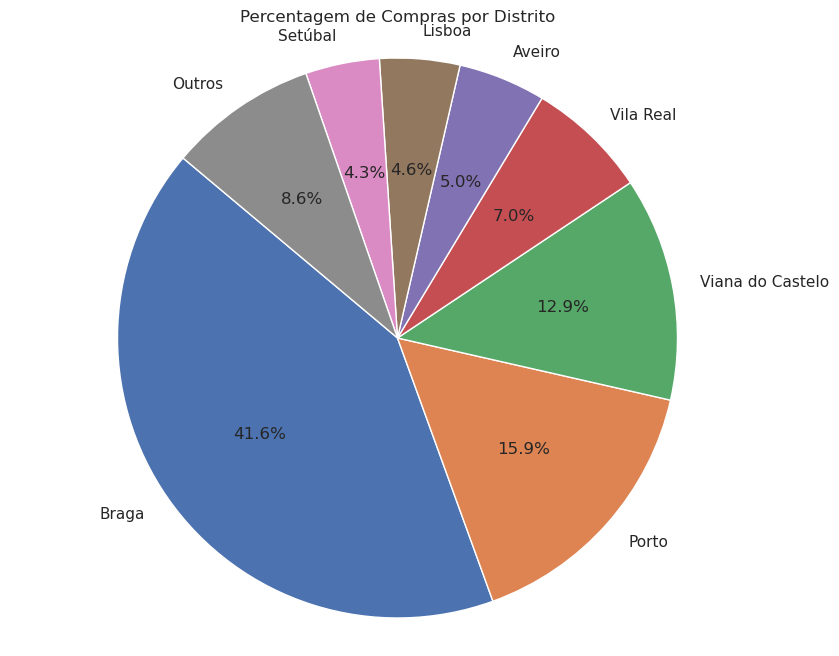

In [650]:
df_vendas_com_distrito = df_vendas.merge(df_clientes[['ClienteId', 'Distrito']], on='ClienteId', how='left')

compras_por_distrito = df_vendas_com_distrito['Distrito'].value_counts()

percentagem_por_distrito = compras_por_distrito / compras_por_distrito.sum() * 100

principais = percentagem_por_distrito[percentagem_por_distrito >= 3]
residuais = percentagem_por_distrito[percentagem_por_distrito < 2]

principais['Outros'] = residuais.sum()

plt.figure(figsize=(10, 8))
plt.pie(principais, labels=principais.index, autopct='%1.1f%%', startangle=140)
plt.title('Percentagem de Compras por Distrito')
plt.axis('equal')
plt.show()

## Percentagem de compras online VS Percentagem de compras em loja fisica
Perceber se os clientes usam mais as lojas fisicas ou a loja online

In [703]:
compras_online = df_vendas[df_vendas['Canal'] == 'Online']
compras_loja = df_vendas[df_vendas['Canal'] == 'Loja Física']

print(f"Número de compras online: {compras_online.shape[0]}")
print(f"Número de compras na loja: {compras_loja.shape[0]}")

fig = go.Figure(data=[go.Pie(labels=['Online', 'Loja Física'],
                             values=[compras_online.shape[0], compras_loja.shape[0]])])
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(title_text="Distribuição de Compras por Canal")
fig.show()

Número de compras online: 2854
Número de compras na loja: 274


### Percentagem de compras por profissão
Tentar perceber se clientes com profissões mais ligadas a IT compram mais na loja

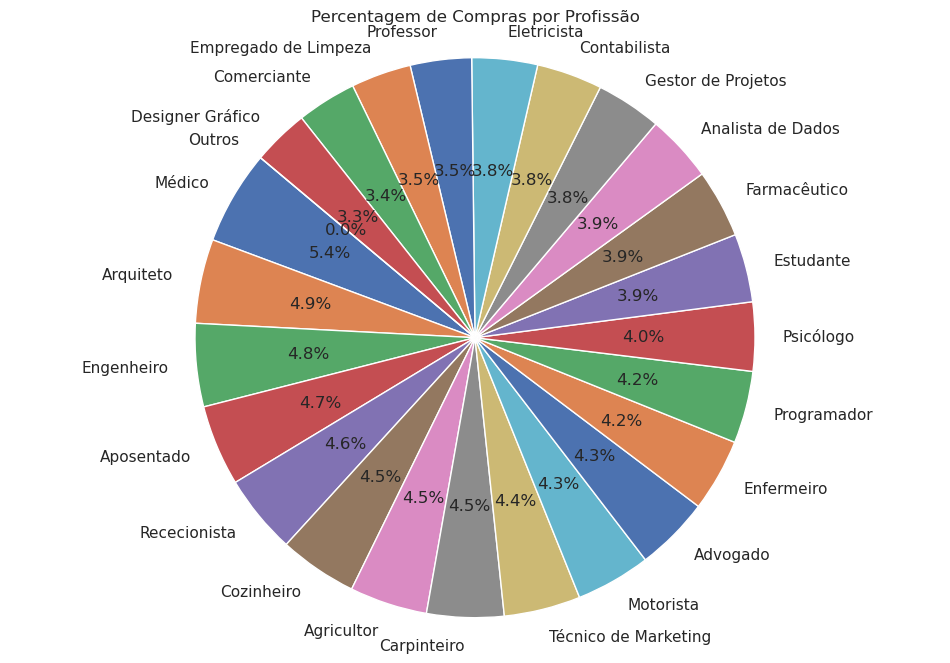

In [651]:
df_vendas_com_profissao = df_vendas.merge(df_clientes[['ClienteId', 'Profissão']], on='ClienteId', how='left')

compras_por_profissao = df_vendas_com_profissao['Profissão'].value_counts()

percentagem_por_profissao = compras_por_profissao / compras_por_profissao.sum() * 100

principais_profissoes = percentagem_por_profissao[percentagem_por_profissao >= 3]
residuais_profissoes = percentagem_por_profissao[percentagem_por_profissao < 3]

principais_profissoes['Outros'] = residuais_profissoes.sum()

plt.figure(figsize=(12, 8))
plt.pie(principais_profissoes, labels=principais_profissoes.index, autopct='%1.1f%%', startangle=140)
plt.title('Percentagem de Compras por Profissão')
plt.axis('equal')
plt.show()


### Percentagem de cada categoria de produto nas compras
Identificar categorias de produto mais compradas para aumentar a oferta das mesmas

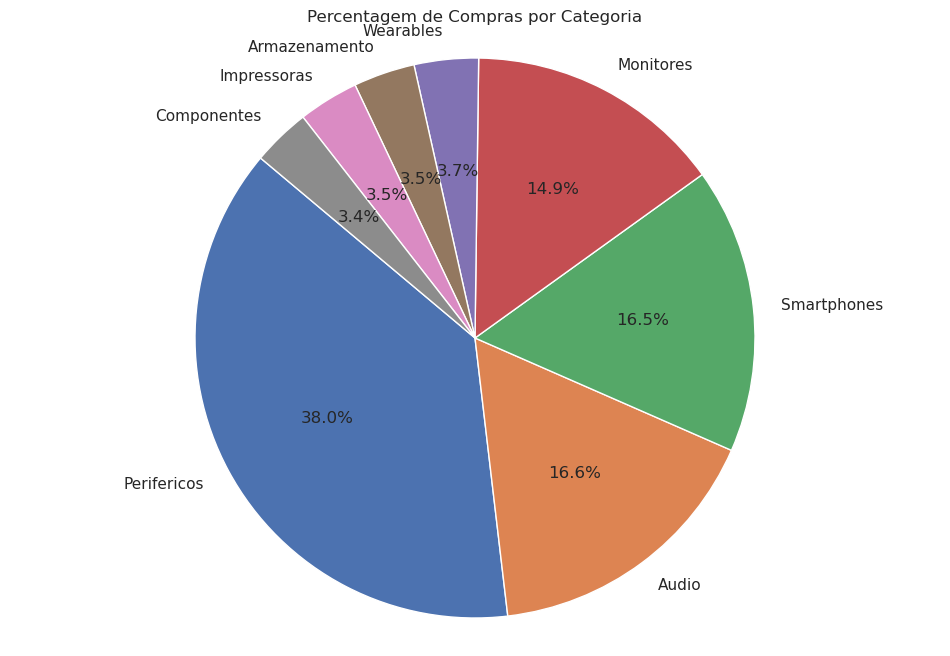

In [652]:
compras_por_categoria = df_vendas.merge(df_produtos[['ProdutoId', 'Categoria']], on='ProdutoId', how='left')
compras_por_categoria = compras_por_categoria['Categoria'].value_counts()
percentagem_por_categoria = compras_por_categoria / compras_por_categoria.sum() * 100
plt.figure(figsize=(12, 8))
plt.pie(percentagem_por_categoria, labels=percentagem_por_categoria.index, autopct='%1.1f%%', startangle=140)
plt.title('Percentagem de Compras por Categoria')
plt.axis('equal')
plt.show()

## Feature engineering

### PrecoFinal
Preço final de uma compra considerando a quntidade, preço unitário e o desconto por unidade

In [653]:
df_vendas['PrecoFinal'] = df_vendas['PrecoUnitario'] * df_vendas['Quantidade'] * (1 - df_vendas['PercentagemDesconto']/100)
df_vendas.head()

,DataId,ClienteId,ProdutoId,Quantidade,PrecoUnitario,PercentagemDesconto,ValorTotal,Canal,PrecoFinal
0,2022-02-23,100,172,2,575.82,26.0,1151.63,Online,852.2136
1,2022-06-02,102,166,4,95.18,7.0,380.70,Online,354.0696
2,2022-04-29,103,135,3,284.75,10.0,854.24,Online,768.8250
3,2023-09-14,103,25,3,495.92,42.0,1487.77,Online,862.9008
4,2024-08-22,103,58,3,264.26,4.0,792.79,Online,761.0688


### Idade

In [654]:
df_clientes['DataNascimento'] = pd.to_datetime(df_clientes['DataNascimento'])

today = pd.Timestamp.today()
df_clientes['Idade'] = df_clientes['DataNascimento'].apply(lambda x: today.year - x.year - ((today.month, today.day) < (x.month, x.day)))

df_clientes.head()

,ClienteId,Nome,Sexo,EstadoCivil,Profissão,Concelho,Distrito,DataNascimento,Idade
0,100,Vicente de Sá,Masculino,Solteiro,Carpinteiro,Sabugal,Guarda,1988-08-31,36
2,102,Yasmin Henriques,Feminino,Divorciado,Estudante,Vizela,Braga,2006-08-09,18
3,103,Micael Almeida,Masculino,Casado,Contabilista,Sertã,Castelo Branco,2002-12-10,22
4,104,Nuno de Branco,Masculino,Solteiro,Gestor de Projetos,Porto,Porto,1954-01-08,71
5,105,Fernando Costa-Costa,Masculino,Solteiro,Aposentado,Braga,Braga,1973-10-20,51


### Percentagem de compras online

In [655]:
compras_online = df_vendas[df_vendas['Canal'] == 'Online'].groupby('ClienteId').size()

compras_totais = df_vendas.groupby('ClienteId').size()

percentagem_online = (compras_online / compras_totais * 100)

df_clientes['PercentagemComprasOnline'] = df_clientes['ClienteId'].map(percentagem_online).fillna(0)

df_clientes.head()


,ClienteId,Nome,Sexo,EstadoCivil,Profissão,Concelho,Distrito,DataNascimento,Idade,PercentagemComprasOnline
0,100,Vicente de Sá,Masculino,Solteiro,Carpinteiro,Sabugal,Guarda,1988-08-31,36,100.0
2,102,Yasmin Henriques,Feminino,Divorciado,Estudante,Vizela,Braga,2006-08-09,18,100.0
3,103,Micael Almeida,Masculino,Casado,Contabilista,Sertã,Castelo Branco,2002-12-10,22,100.0
4,104,Nuno de Branco,Masculino,Solteiro,Gestor de Projetos,Porto,Porto,1954-01-08,71,100.0
5,105,Fernando Costa-Costa,Masculino,Solteiro,Aposentado,Braga,Braga,1973-10-20,51,100.0


### Frequencia
Total de transações e de produtos comprados

In [656]:
df_vendas['VendaId'] = df_vendas['DataId'].astype(str) + '_' + df_vendas['ClienteId'].astype(str)

total_transacoes = df_vendas.groupby('ClienteId')['VendaId'].nunique().reset_index()
total_transacoes.rename(columns={'VendaId': 'TotalTransacoes'}, inplace=True)

total_compras = df_vendas.groupby('ClienteId')['Quantidade'].sum().reset_index()
total_compras.rename(columns={'Quantidade': 'TotalCompras'}, inplace=True)

df_clientes = pd.merge(df_clientes, total_transacoes, on='ClienteId', how='left')
df_clientes = pd.merge(df_clientes, total_compras, on='ClienteId', how='left')

df_clientes.head(3)

,ClienteId,Nome,Sexo,EstadoCivil,Profissão,Concelho,Distrito,DataNascimento,Idade,PercentagemComprasOnline,TotalTransacoes,TotalCompras
0,100,Vicente de Sá,Masculino,Solteiro,Carpinteiro,Sabugal,Guarda,1988-08-31,36,100.0,1,2
1,102,Yasmin Henriques,Feminino,Divorciado,Estudante,Vizela,Braga,2006-08-09,18,100.0,1,4
2,103,Micael Almeida,Masculino,Casado,Contabilista,Sertã,Castelo Branco,2002-12-10,22,100.0,3,9


### Total gasto e Valor Médio de transações

In [657]:
df_vendas['Total_Spend'] = df_vendas['PrecoUnitario'] * df_vendas['Quantidade'] * (1 - df_vendas['PercentagemDesconto']/100)
total_spend = df_vendas.groupby('ClienteId')['Total_Spend'].sum().reset_index()

total_transactions = df_vendas.groupby('ClienteId').size().reset_index(name='Total_Transactions')

average_transaction_value = total_spend.merge(total_transactions, on='ClienteId')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend'] / average_transaction_value['Total_Transactions']

customer_data = df_clientes.copy()

customer_data = pd.merge(customer_data, total_spend, on='ClienteId', how='left')
customer_data = pd.merge(customer_data, average_transaction_value[['ClienteId', 'Average_Transaction_Value']], on='ClienteId', how='left')

customer_data.head(3)

,ClienteId,Nome,Sexo,EstadoCivil,Profissão,Concelho,Distrito,DataNascimento,Idade,PercentagemComprasOnline,TotalTransacoes,TotalCompras,Total_Spend,Average_Transaction_Value
0,100,Vicente de Sá,Masculino,Solteiro,Carpinteiro,Sabugal,Guarda,1988-08-31,36,100.0,1,2,852.2136,852.2136
1,102,Yasmin Henriques,Feminino,Divorciado,Estudante,Vizela,Braga,2006-08-09,18,100.0,1,4,354.0696,354.0696
2,103,Micael Almeida,Masculino,Casado,Contabilista,Sertã,Castelo Branco,2002-12-10,22,100.0,3,9,2392.7946,797.5982


### Diversidade de produtos

Produtos unicos comprados

In [658]:
unique_products_purchased = df_vendas.groupby('ClienteId')['ProdutoId'].nunique().reset_index()
unique_products_purchased.rename(columns={'ProdutoId': 'ProdutosUnicosComprados'}, inplace=True)

customer_data = pd.merge(customer_data, unique_products_purchased, on='ClienteId')

customer_data.head(3)

,ClienteId,Nome,Sexo,EstadoCivil,Profissão,Concelho,Distrito,DataNascimento,Idade,PercentagemComprasOnline,TotalTransacoes,TotalCompras,Total_Spend,Average_Transaction_Value,ProdutosUnicosComprados
0,100,Vicente de Sá,Masculino,Solteiro,Carpinteiro,Sabugal,Guarda,1988-08-31,36,100.0,1,2,852.2136,852.2136,1
1,102,Yasmin Henriques,Feminino,Divorciado,Estudante,Vizela,Braga,2006-08-09,18,100.0,1,4,354.0696,354.0696,1
2,103,Micael Almeida,Masculino,Casado,Contabilista,Sertã,Castelo Branco,2002-12-10,22,100.0,3,9,2392.7946,797.5982,3


### Media de dias entre compras e Dia e Hora favoritos para comprar

In [659]:
# Convert date and create time features
df_vendas['DataCompra'] = pd.to_datetime(df_vendas['DataId'])
df_vendas['Day_Of_Week'] = df_vendas['DataCompra'].dt.dayofweek
df_vendas['Hour'] = 12  # Setting a default hour
df_vendas = df_vendas.sort_values(['ClienteId', 'DataCompra'])
df_vendas['InvoiceDay'] = df_vendas['DataCompra'].dt.date

# Calculate days between purchases
days_between_purchases = df_vendas.groupby('ClienteId')['InvoiceDay'].apply(
    lambda x: (x.diff()).dropna().apply(lambda y: y.days)
)

# Count number of purchases per customer
purchase_counts = df_vendas.groupby('ClienteId').size().reset_index(name='Purchase_Count')

# Get unique customers list
all_customers = df_vendas['ClienteId'].unique()

# Calculate average days between purchases for multi-purchase customers
average_days_between_purchases = days_between_purchases.groupby('ClienteId').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)

# Find favorite shopping day
favorite_shopping_day = df_vendas.groupby(['ClienteId', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('ClienteId')['Count'].idxmax()][['ClienteId', 'Day_Of_Week']]

# Find favorite shopping hour
favorite_shopping_hour = df_vendas.groupby(['ClienteId', 'Hour']).size().reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('ClienteId')['Count'].idxmax()][['ClienteId', 'Hour']]

# Create a copy of customer data for merging
customer_data = customer_data.copy()

# Create a DataFrame with all customers and their purchase counts
purchase_counts = df_vendas.groupby('ClienteId').size().reset_index(name='Purchase_Count')

# Identify single-purchase customers
single_purchase_mask = purchase_counts['Purchase_Count'] == 1
single_purchase_customers = purchase_counts.loc[single_purchase_mask, 'ClienteId']

# For average_days_between_purchases, use a special value for single-purchase customers
# First create a DataFrame with all customers
all_avg_days = pd.DataFrame({'ClienteId': all_customers})

# Then merge with the existing average days calculation
all_avg_days = pd.merge(all_avg_days, average_days_between_purchases, on='ClienteId', how='left')

# Fill NaN with a special value that indicates single purchase
# Using -1 as an indicator that this is a single-purchase customer (or another value that makes sense)
all_avg_days['Average_Days_Between_Purchases'] = all_avg_days['Average_Days_Between_Purchases'].fillna(-1)

# Merge all the features
customer_data = pd.merge(customer_data, purchase_counts, on='ClienteId', how='left')
customer_data = pd.merge(customer_data, all_avg_days, on='ClienteId', how='left')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='ClienteId', how='left')
customer_data = pd.merge(customer_data, favorite_shopping_hour, on='ClienteId', how='left')

# Add a flag for single-purchase customers
customer_data['Single_Purchase'] = customer_data['Purchase_Count'] == 1
print(f"Number of single-purchase customers: {customer_data['Single_Purchase'].sum()}")

# Map day of week numbers to day names
day_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 
               4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
customer_data['Favorite_Shopping_Day'] = customer_data['Day_Of_Week'].map(day_mapping)

# Preview the result
customer_data.head(3)

Number of single-purchase customers: 666


,ClienteId,Nome,Sexo,EstadoCivil,Profissão,Concelho,Distrito,DataNascimento,Idade,PercentagemComprasOnline,...,TotalCompras,Total_Spend,Average_Transaction_Value,ProdutosUnicosComprados,Purchase_Count,Average_Days_Between_Purchases,Day_Of_Week,Hour,Single_Purchase,Favorite_Shopping_Day
0,100,Vicente de Sá,Masculino,Solteiro,Carpinteiro,Sabugal,Guarda,1988-08-31,36,100.0,...,2,852.2136,852.2136,1,1,-1.0,2,12,True,Wednesday
1,102,Yasmin Henriques,Feminino,Divorciado,Estudante,Vizela,Braga,2006-08-09,18,100.0,...,4,354.0696,354.0696,1,1,-1.0,3,12,True,Thursday
2,103,Micael Almeida,Masculino,Casado,Contabilista,Sertã,Castelo Branco,2002-12-10,22,100.0,...,9,2392.7946,797.5982,3,3,423.0,3,12,False,Thursday


### Media de gastos mensais

In [660]:
df_vendas['DataCompra'] = pd.to_datetime(df_vendas['DataId'])

df_vendas['Year'] = df_vendas['DataCompra'].dt.year
df_vendas['Month'] = df_vendas['DataCompra'].dt.month

if 'Total_Spend' not in df_vendas.columns:
    df_vendas['Total_Spend'] = df_vendas['PrecoUnitario'] * df_vendas['Quantidade'] * (1 - df_vendas['PercentagemDesconto']/100)

monthly_spending = df_vendas.groupby(['ClienteId', 'Year', 'Month'])['Total_Spend'].sum().reset_index()

seasonal_buying_patterns = monthly_spending.groupby('ClienteId')['Total_Spend'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)

seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)

def calculate_trend(spend_data):
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
    else:
        return 0

spending_trends = monthly_spending.groupby('ClienteId')['Total_Spend'].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'Total_Spend': 'Spending_Trend'}, inplace=True)

if 'customer_data' not in locals():
    customer_data = df_clientes.copy()

customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='ClienteId', how='left')
customer_data = pd.merge(customer_data, spending_trends, on='ClienteId', how='left')

customer_data['Monthly_Spending_Mean'] = customer_data['Monthly_Spending_Mean'].apply(lambda x: -1 if x == 0.0 else x)
customer_data['Spending_Trend'] = customer_data['Spending_Trend'].apply(lambda x: -1 if x == 0.0 else x)
customer_data['Monthly_Spending_Std'] = customer_data['Monthly_Spending_Std'].apply(lambda x: -1 if x == 0.0 else x)

customer_data.head(3)

,ClienteId,Nome,Sexo,EstadoCivil,Profissão,Concelho,Distrito,DataNascimento,Idade,PercentagemComprasOnline,...,ProdutosUnicosComprados,Purchase_Count,Average_Days_Between_Purchases,Day_Of_Week,Hour,Single_Purchase,Favorite_Shopping_Day,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,100,Vicente de Sá,Masculino,Solteiro,Carpinteiro,Sabugal,Guarda,1988-08-31,36,100.0,...,1,1,-1.0,2,12,True,Wednesday,852.2136,-1.000000,-1.0000
1,102,Yasmin Henriques,Feminino,Divorciado,Estudante,Vizela,Braga,2006-08-09,18,100.0,...,1,1,-1.0,3,12,True,Thursday,354.0696,-1.000000,-1.0000
2,103,Micael Almeida,Masculino,Casado,Contabilista,Sertã,Castelo Branco,2002-12-10,22,100.0,...,3,3,423.0,3,12,False,Thursday,797.5982,56.686523,-3.8781


In [661]:
customer_data['ClienteId'] = customer_data['ClienteId'].astype(str)

customer_data = customer_data.convert_dtypes()

customer_data.head(10)

,ClienteId,Nome,Sexo,EstadoCivil,Profissão,Concelho,Distrito,DataNascimento,Idade,PercentagemComprasOnline,...,ProdutosUnicosComprados,Purchase_Count,Average_Days_Between_Purchases,Day_Of_Week,Hour,Single_Purchase,Favorite_Shopping_Day,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,100,Vicente de Sá,Masculino,Solteiro,Carpinteiro,Sabugal,Guarda,1988-08-31,36,100.0,...,1,1,-1.0,2,12,True,Wednesday,852.2136,-1.0,-1.0
1,102,Yasmin Henriques,Feminino,Divorciado,Estudante,Vizela,Braga,2006-08-09,18,100.0,...,1,1,-1.0,3,12,True,Thursday,354.0696,-1.0,-1.0
2,103,Micael Almeida,Masculino,Casado,Contabilista,Sertã,Castelo Branco,2002-12-10,22,100.0,...,3,3,423.0,3,12,False,Thursday,797.5982,56.686523,-3.8781
3,104,Nuno de Branco,Masculino,Solteiro,Gestor de Projetos,Porto,Porto,1954-01-08,71,100.0,...,4,4,151.333333,2,12,False,Wednesday,765.533433,178.464811,-121.8208
4,105,Fernando Costa-Costa,Masculino,Solteiro,Aposentado,Braga,Braga,1973-10-20,51,100.0,...,1,1,-1.0,0,12,True,Monday,1089.9825,-1.0,-1.0
5,106,Valentim Amorim,Masculino,Solteiro,Analista de Dados,Vila Nova de Gaia,Porto,1967-12-25,57,100.0,...,1,1,-1.0,3,12,True,Thursday,265.8084,-1.0,-1.0
6,107,Alice Valente,Feminino,Viúvo,Motorista,Alijó,Vila Real,1989-05-29,35,100.0,...,3,3,28.0,6,12,False,Sunday,589.126333,498.911518,496.8951
7,108,Márcio Moura,Masculino,Viúvo,Enfermeiro,Seixal,Setúbal,1982-02-27,43,100.0,...,3,3,655.0,0,12,False,Monday,1142.2294,21.673389,-30.6508
8,109,Bárbara Ferreira,Feminino,Solteiro,Estudante,Braga,Braga,1944-09-08,80,100.0,...,2,2,630.0,3,12,False,Thursday,397.99665,289.320306,-409.1607
9,110,Lúcia Tavares,Feminino,Viúvo,Empregado de Limpeza,Fafe,Braga,1967-03-08,58,100.0,...,1,1,-1.0,2,12,True,Wednesday,782.886,-1.0,-1.0


### Recência da primeira compra

Perceber se o cliente é efetivamente novo ou se apenas comprou uma veze e não voltou

In [662]:
df_vendas['DataCompra'] = pd.to_datetime(df_vendas['DataId'])

last_date_in_data = df_vendas['DataCompra'].max()

first_purchase_dates = df_vendas.groupby('ClienteId')['DataCompra'].min().reset_index()
first_purchase_dates.rename(columns={'DataCompra': 'First_Purchase_Date'}, inplace=True)

first_purchase_dates['Recency_First_Purchase_Days'] = (
    last_date_in_data - first_purchase_dates['First_Purchase_Date']
).dt.days

customer_data['ClienteId'] = customer_data['ClienteId'].astype(str)
first_purchase_dates['ClienteId'] = first_purchase_dates['ClienteId'].astype(str)

customer_data = pd.merge(
    customer_data,
    first_purchase_dates[['ClienteId', 'Recency_First_Purchase_Days']],
    on='ClienteId',
    how='left'
)

customer_data.head()

,ClienteId,Nome,Sexo,EstadoCivil,Profissão,Concelho,Distrito,DataNascimento,Idade,PercentagemComprasOnline,...,Purchase_Count,Average_Days_Between_Purchases,Day_Of_Week,Hour,Single_Purchase,Favorite_Shopping_Day,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Recency_First_Purchase_Days
0,100,Vicente de Sá,Masculino,Solteiro,Carpinteiro,Sabugal,Guarda,1988-08-31,36,100.0,...,1,-1.0,2,12,True,Wednesday,852.2136,-1.0,-1.0,1142
1,102,Yasmin Henriques,Feminino,Divorciado,Estudante,Vizela,Braga,2006-08-09,18,100.0,...,1,-1.0,3,12,True,Thursday,354.0696,-1.0,-1.0,1043
2,103,Micael Almeida,Masculino,Casado,Contabilista,Sertã,Castelo Branco,2002-12-10,22,100.0,...,3,423.0,3,12,False,Thursday,797.5982,56.686523,-3.8781,1077
3,104,Nuno de Branco,Masculino,Solteiro,Gestor de Projetos,Porto,Porto,1954-01-08,71,100.0,...,4,151.333333,2,12,False,Wednesday,765.533433,178.464811,-121.8208,536
4,105,Fernando Costa-Costa,Masculino,Solteiro,Aposentado,Braga,Braga,1973-10-20,51,100.0,...,1,-1.0,0,12,True,Monday,1089.9825,-1.0,-1.0,1221


### Categoria mais comprada

In [663]:
df_vendas = df_vendas.merge(df_produtos[['ProdutoId', 'Categoria']], on='ProdutoId', how='left')

compras_por_categoria = df_vendas.groupby(['ClienteId', 'Categoria']).size().reset_index(name='NumCompras')

categoria_favorita = compras_por_categoria.loc[
    compras_por_categoria.groupby('ClienteId')['NumCompras'].idxmax()
]

categoria_favorita.rename(columns={'Categoria': 'CategoriaFavorita'}, inplace=True)

customer_data['ClienteId'] = customer_data['ClienteId'].astype('int64')
categoria_favorita['ClienteId'] = categoria_favorita['ClienteId'].astype('int64')

customer_data = customer_data.merge(categoria_favorita[['ClienteId', 'CategoriaFavorita']], on='ClienteId', how='left')

customer_data.head(3)


,ClienteId,Nome,Sexo,EstadoCivil,Profissão,Concelho,Distrito,DataNascimento,Idade,PercentagemComprasOnline,...,Average_Days_Between_Purchases,Day_Of_Week,Hour,Single_Purchase,Favorite_Shopping_Day,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Recency_First_Purchase_Days,CategoriaFavorita
0,100,Vicente de Sá,Masculino,Solteiro,Carpinteiro,Sabugal,Guarda,1988-08-31,36,100.0,...,-1.0,2,12,True,Wednesday,852.2136,-1.0,-1.0,1142,Perifericos
1,102,Yasmin Henriques,Feminino,Divorciado,Estudante,Vizela,Braga,2006-08-09,18,100.0,...,-1.0,3,12,True,Thursday,354.0696,-1.0,-1.0,1043,Perifericos
2,103,Micael Almeida,Masculino,Casado,Contabilista,Sertã,Castelo Branco,2002-12-10,22,100.0,...,423.0,3,12,False,Thursday,797.5982,56.686523,-3.8781,1077,Smartphones


In [664]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1564 entries, 0 to 1563
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   ClienteId                       1564 non-null   int64         
 1   Nome                            1564 non-null   string        
 2   Sexo                            1564 non-null   string        
 3   EstadoCivil                     1564 non-null   string        
 4   Profissão                       1564 non-null   string        
 5   Concelho                        1564 non-null   string        
 6   Distrito                        1564 non-null   string        
 7   DataNascimento                  1564 non-null   datetime64[ns]
 8   Idade                           1564 non-null   Int64         
 9   PercentagemComprasOnline        1564 non-null   Float64       
 10  TotalTransacoes                 1564 non-null   Int64         
 11  Tota

## Deteção e tratamento de outliers

In [665]:
model = IsolationForest(contamination=0.05, random_state=0)

numeric_columns = customer_data.select_dtypes(include=['number']).columns

numeric_data = customer_data[numeric_columns].fillna(customer_data[numeric_columns].mean())

customer_data['Outlier_Scores'] = model.fit_predict(numeric_data.to_numpy())

customer_data['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_data['Outlier_Scores']]

customer_data.head()

,ClienteId,Nome,Sexo,EstadoCivil,Profissão,Concelho,Distrito,DataNascimento,Idade,PercentagemComprasOnline,...,Hour,Single_Purchase,Favorite_Shopping_Day,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Recency_First_Purchase_Days,CategoriaFavorita,Outlier_Scores,Is_Outlier
0,100,Vicente de Sá,Masculino,Solteiro,Carpinteiro,Sabugal,Guarda,1988-08-31,36,100.0,...,12,True,Wednesday,852.2136,-1.0,-1.0,1142,Perifericos,1,0
1,102,Yasmin Henriques,Feminino,Divorciado,Estudante,Vizela,Braga,2006-08-09,18,100.0,...,12,True,Thursday,354.0696,-1.0,-1.0,1043,Perifericos,1,0
2,103,Micael Almeida,Masculino,Casado,Contabilista,Sertã,Castelo Branco,2002-12-10,22,100.0,...,12,False,Thursday,797.5982,56.686523,-3.8781,1077,Smartphones,1,0
3,104,Nuno de Branco,Masculino,Solteiro,Gestor de Projetos,Porto,Porto,1954-01-08,71,100.0,...,12,False,Wednesday,765.533433,178.464811,-121.8208,536,Perifericos,1,0
4,105,Fernando Costa-Costa,Masculino,Solteiro,Aposentado,Braga,Braga,1973-10-20,51,100.0,...,12,True,Monday,1089.9825,-1.0,-1.0,1221,Perifericos,1,0


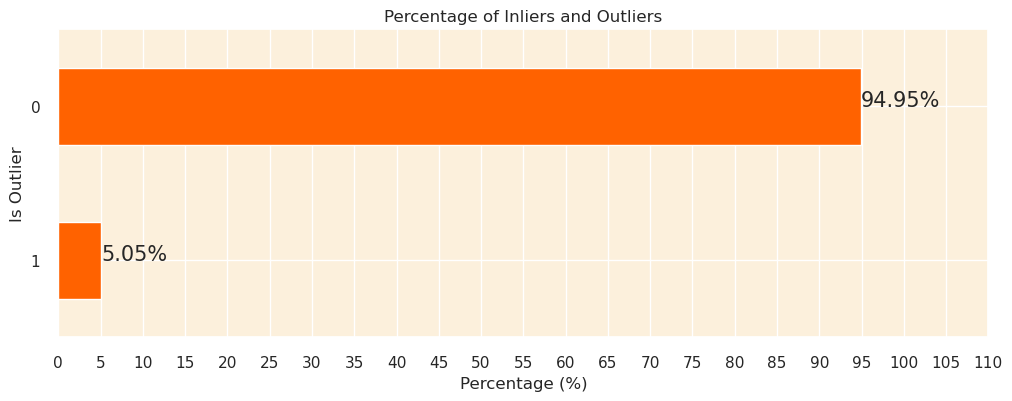

In [666]:
outlier_percentage = customer_data['Is_Outlier'].value_counts(normalize=True) * 100

plt.figure(figsize=(12, 4))
outlier_percentage.plot(kind='barh', color='#ff6200')

for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Percentage of Inliers and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()

In [667]:
outliers_data = customer_data[customer_data['Is_Outlier'] == 1]

customer_data_cleaned = customer_data[customer_data['Is_Outlier'] == 0]

customer_data_cleaned = customer_data_cleaned.drop(columns=['Outlier_Scores', 'Is_Outlier'])

customer_data_cleaned.reset_index(drop=True, inplace=True)

In [668]:
customer_data_cleaned.shape[0]

1485

## Correlation analysis

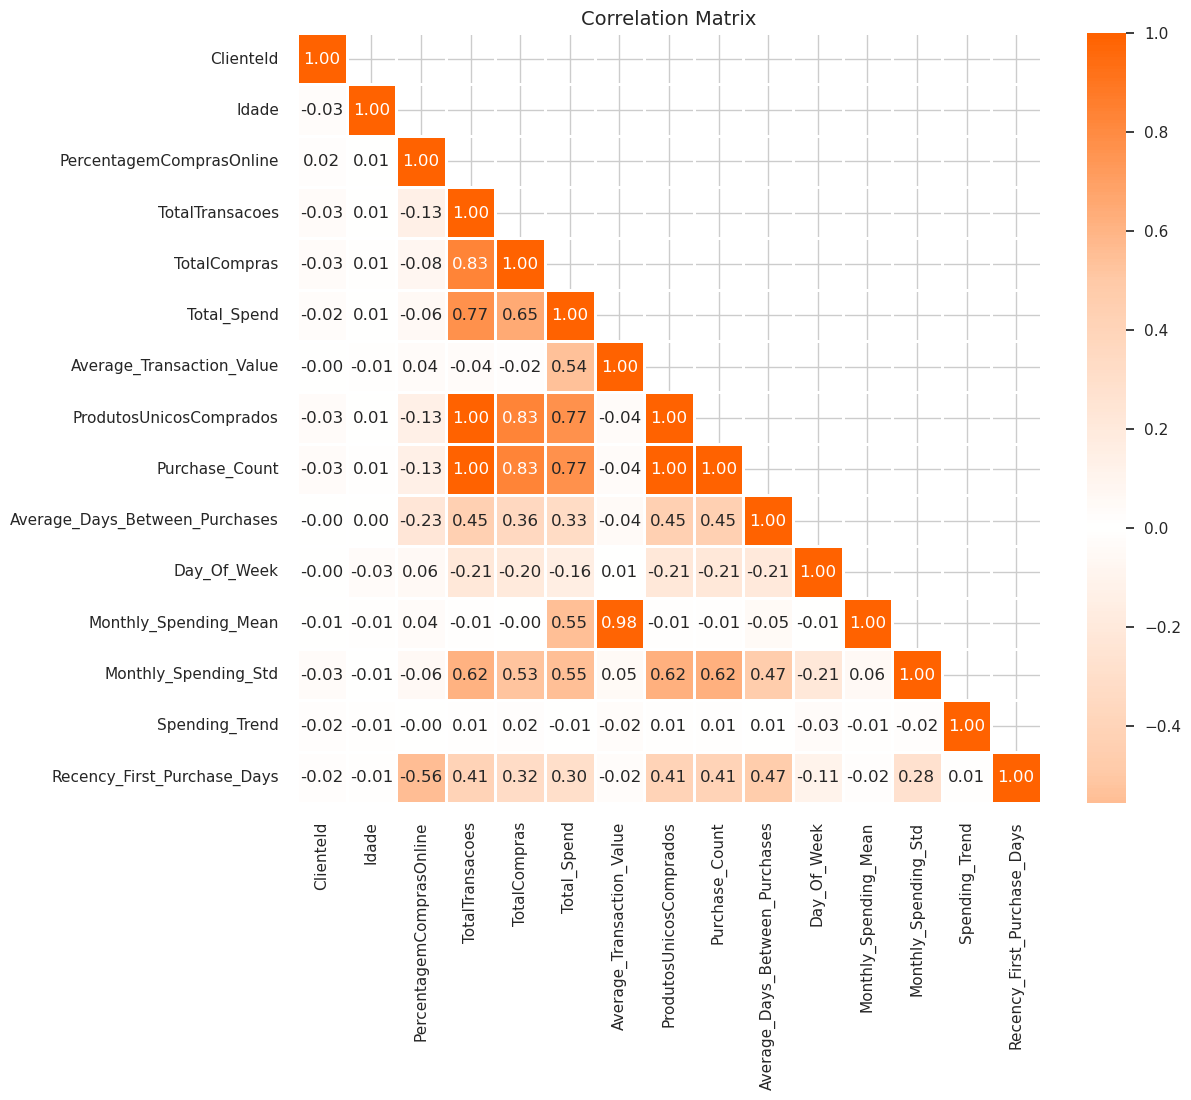

In [669]:
sns.set_style('whitegrid')

numeric_columns = customer_data_cleaned.select_dtypes(include=['number']).columns
numeric_columns = [col for col in numeric_columns if col != 'Hour']

corr = customer_data_cleaned[numeric_columns].corr()

colors = ['#ff6200', '#ffcaa8', 'white', '#ffcaa8', '#ff6200']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

## Feature scaling

In [670]:
# Initialize the StandardScaler
scaler = StandardScaler()

# List of columns that don't need to be scaled
columns_to_exclude = ['ClienteId', 'Day_Of_Week', 'Nome', 'Sexo', 'DataId', 'DataCompra', 'InvoiceDay', 'Favorite_Shopping_Day', 'Concelho', 'Distrito', 'DataNascimento', 'EstadoCivil', 'Profissão', 'CategoriaFavorita']

# List of columns that need to be scaled
columns_to_scale = customer_data_cleaned.columns.difference(columns_to_exclude)

# Copy the cleaned dataset
customer_data_scaled = customer_data_cleaned.copy()

# Applying the scaler to the necessary columns in the dataset
customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

# Display the first few rows of the scaled data
customer_data_scaled.head()

,ClienteId,Nome,Sexo,EstadoCivil,Profissão,Concelho,Distrito,DataNascimento,Idade,PercentagemComprasOnline,...,Average_Days_Between_Purchases,Day_Of_Week,Hour,Single_Purchase,Favorite_Shopping_Day,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Recency_First_Purchase_Days,CategoriaFavorita
0,100,Vicente de Sá,Masculino,Solteiro,Carpinteiro,Sabugal,Guarda,1988-08-31,-0.701921,0.133873,...,-0.750784,2,0.0,1.114990,Wednesday,0.930679,-0.808743,-0.001203,0.250816,Perifericos
1,102,Yasmin Henriques,Feminino,Divorciado,Estudante,Vizela,Braga,2006-08-09,-1.690402,0.133873,...,-0.750784,3,0.0,1.114990,Thursday,-0.797064,-0.808743,-0.001203,0.066561,Perifericos
2,103,Micael Almeida,Masculino,Casado,Contabilista,Sertã,Castelo Branco,2002-12-10,-1.470739,0.133873,...,0.457689,3,0.0,-0.896869,Thursday,0.741253,-0.534538,-0.010316,0.129840,Smartphones
3,104,Nuno de Branco,Masculino,Solteiro,Gestor de Projetos,Porto,Porto,1954-01-08,1.220125,0.133873,...,-0.316607,2,0.0,-0.896869,Wednesday,0.630041,0.044317,-0.383738,-0.877049,Perifericos
4,105,Fernando Costa-Costa,Masculino,Solteiro,Aposentado,Braga,Braga,1973-10-20,0.121813,0.133873,...,-0.750784,0,0.0,1.114990,Monday,1.755347,-0.808743,-0.001203,0.397848,Perifericos


## Dimensionality reduction

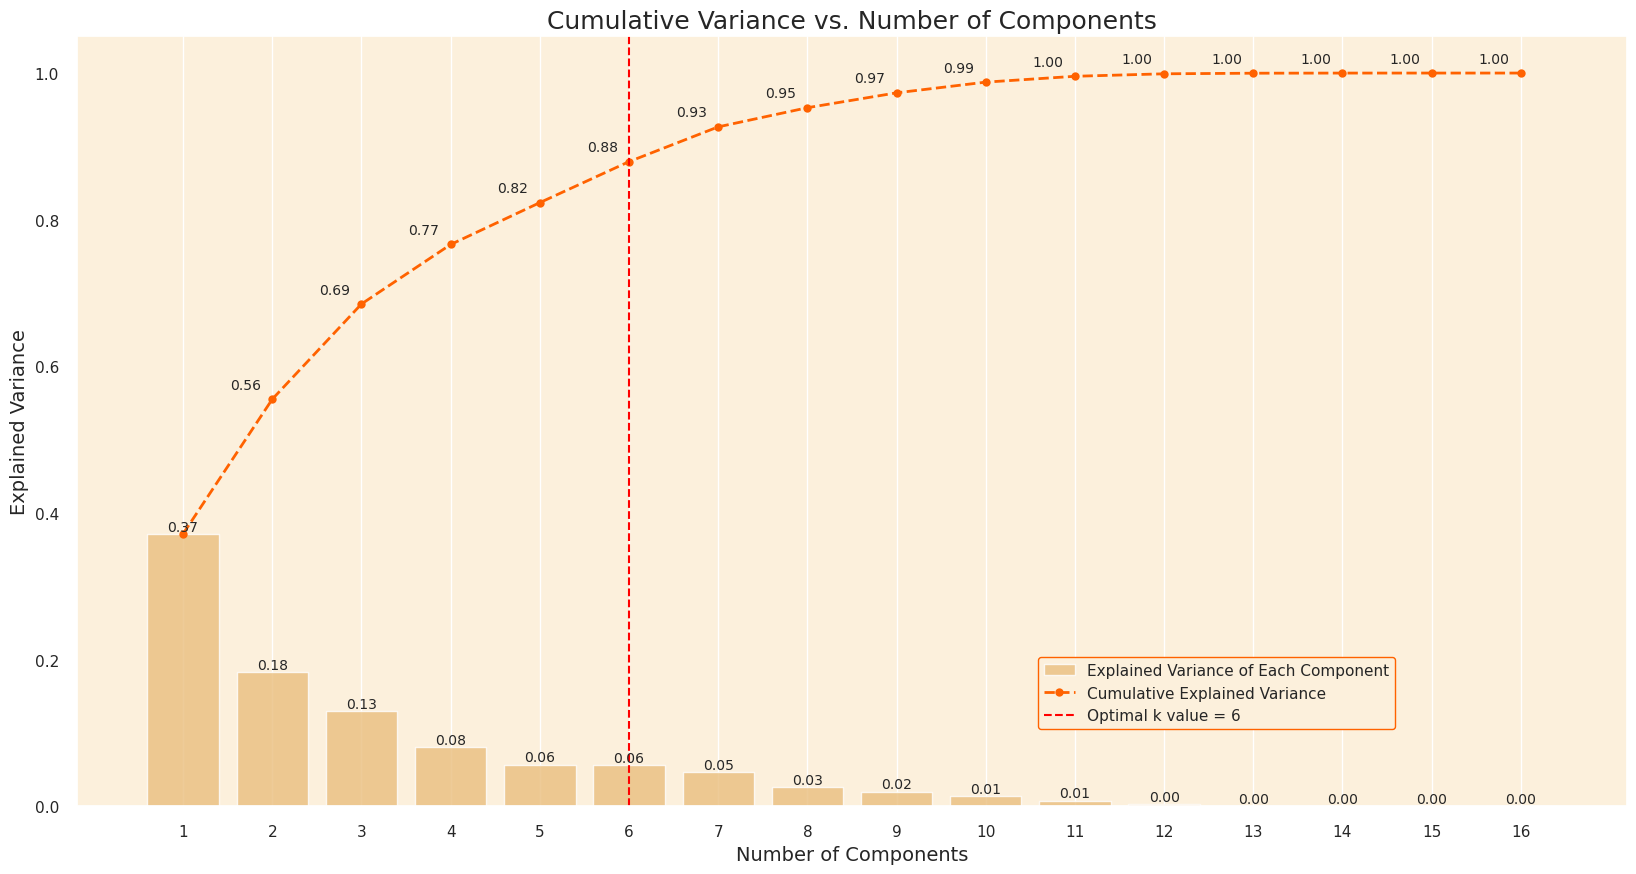

In [671]:
# Make sure we use only numeric columns for PCA
numeric_columns = customer_data_scaled.select_dtypes(include=['number']).columns
customer_data_numeric = customer_data_scaled[numeric_columns]

# Set CustomerID as the index if it's not already
if 'ClienteId' in customer_data_numeric.columns:
    customer_data_numeric.set_index('ClienteId', inplace=True)

# Fill missing values with the mean of each column
customer_data_numeric_imputed = customer_data_numeric.fillna(customer_data_numeric.mean())

# Apply PCA
pca = PCA().fit(customer_data_numeric_imputed)

# Calculate the Cumulative Sum of the Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Set the optimal k value (based on our analysis, we can choose 6)
optimal_k = 6

# Set seaborn plot style
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

# Plot the cumulative explained variance against the number of components
plt.figure(figsize=(20, 10))

# Bar chart for the explained variance of each component
barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                     y=explained_variance_ratio,
                     color='#fcc36d',
                     alpha=0.8)

# Line plot for the cumulative explained variance
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                    marker='o', linestyle='--', color='#ff6200', linewidth=2)

# Plot optimal k value line
optimal_k_line = plt.axvline(optimal_k - 1, color='red', linestyle='--', label=f'Optimal k value = {optimal_k}')

# Set labels and title
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

# Customize ticks and legend
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
          labels=['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Optimal k value = {optimal_k}'],
          loc=(0.62, 0.1),
          frameon=True,
          framealpha=1.0,
          edgecolor='#ff6200')

# Display the variance values for both graphs on the plots
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')
plt.show()

In [672]:
# Creating a PCA object with 6 components
pca = PCA(n_components=6)

# Fitting and transforming the original data to the new PCA dataframe
customer_data_pca = pca.fit_transform(customer_data_numeric_imputed)

# Creating a new dataframe from the PCA dataframe, with columns labeled PC1, PC2, etc.
customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# Adding the CustomerID index back to the new PCA dataframe
customer_data_pca.index = customer_data_numeric_imputed.index

In [673]:
# Displaying the resulting dataframe based on the PCs
customer_data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
ClienteId,,,,,,
100,1.929799,-0.996494,1.525143,-0.725091,0.473437,-0.464238
102,2.467607,-0.329082,-1.030016,-0.201238,1.109486,-1.242186
103,-2.128217,1.783982,1.166907,0.288069,1.010350,-0.974308
104,-3.428376,1.215728,0.615880,1.748904,-0.892925,0.865071
105,1.081994,-2.714107,2.864662,-0.980753,-0.048801,0.147309


In [674]:
# Define a function to highlight the top 3 absolute values in each column of a dataframe
def highlight_top3(column):
    top3 = column.abs().nlargest(3).index
    return ['background-color:  #ffeacc' if i in top3 else '' for i in column.index]

# Garante que usas as mesmas colunas que foram usadas no PCA
features_used = customer_data_numeric_imputed.columns[:pca.components_.shape[1]]

pc_df = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=features_used
)

# Desta forma, aplica o estilo corretamente
pc_df.style.apply(highlight_top3, axis=0)


,PC1,PC2,PC3,PC4,PC5,PC6
Idade,-0.006826,-0.020306,-0.007315,0.044749,-0.638980,0.765872
PercentagemComprasOnline,0.076425,-0.018248,0.108172,0.697429,0.010944,-0.049151
TotalTransacoes,-0.355396,0.163756,-0.061579,0.114166,0.018809,0.018359
TotalCompras,-0.312164,0.137012,-0.045977,0.151423,0.034371,0.040222
Total_Spend,-0.297059,0.173996,0.331948,0.044028,0.006546,0.021656
Average_Transaction_Value,-0.021045,0.060996,0.642544,-0.123606,-0.004306,0.007974
ProdutosUnicosComprados,-0.355384,0.162741,-0.062067,0.113567,0.020084,0.020795
Purchase_Count,-0.355441,0.164050,-0.061175,0.114979,0.020076,0.021754
Average_Days_Between_Purchases,-0.232789,0.041637,-0.113051,-0.259931,-0.056083,-0.057138
Day_Of_Week,0.381970,0.916159,-0.084409,-0.009948,-0.004539,0.019834


## K-means clustering

### Nº optimo de clusters - Elbow method

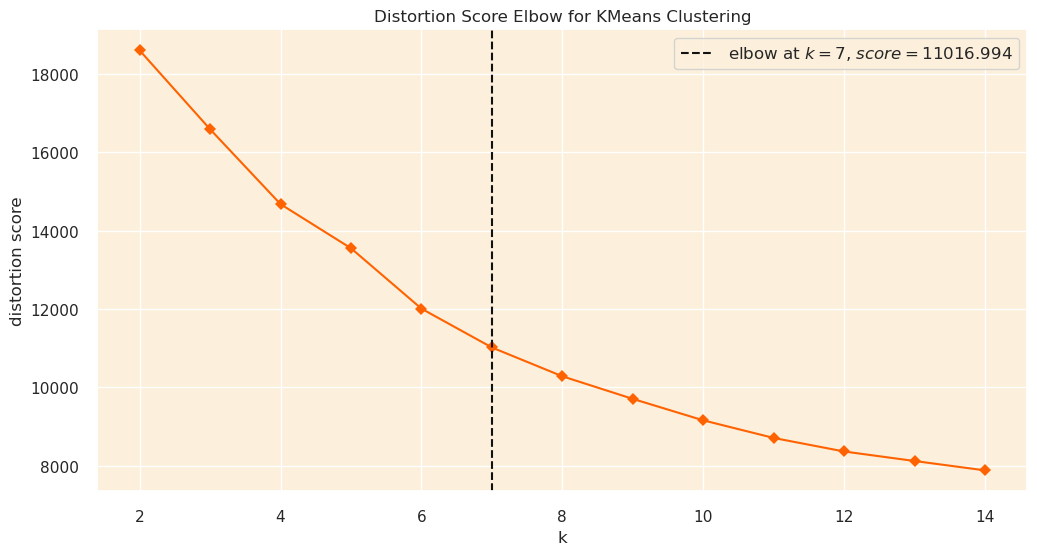

In [675]:
# Set plot style, and background color
sns.set(style='darkgrid', rc={'axes.facecolor': '#fcf0dc'})

# Set the color palette for the plot
sns.set_palette(['#ff6200'])

# Instantiate the clustering model with the specified parameters
km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0)

# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(12, 6))

# Instantiate the KElbowVisualizer with the model and range of k values, and disable the timing plot
visualizer = KElbowVisualizer(km, k=(2, 15), timings=False, ax=ax)

# Fit the data to the visualizer
visualizer.fit(customer_data_numeric_imputed)

# Finalize and render the figure
visualizer.show();

### Nº optimo de clusters - Silhouette method

In [676]:
def silhouette_analysis(df, start_k, stop_k, figsize=(15, 16)):
    """
    Perform Silhouette analysis for a range of k values and visualize the results.
    """

    # Set the size of the figure
    plt.figure(figsize=figsize)

    # Create a grid with (stop_k - start_k + 1) rows and 2 columns
    grid = gridspec.GridSpec(stop_k - start_k + 1, 2)

    # Assign the first plot to the first row and both columns
    first_plot = plt.subplot(grid[0, :])

    # First plot: Silhouette scores for different k values
    sns.set_palette(['darkorange'])

    silhouette_scores = []

    # Iterate through the range of k values
    for k in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=0)
        km.fit(df)
        labels = km.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)

    best_k = start_k + silhouette_scores.index(max(silhouette_scores))

    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)

    # Add the optimal k value text to the plot
    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom', 
             horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))
             

    # Second plot (subplot): Silhouette plots for each k value
    colors = sns.color_palette("bright")

    for i in range(start_k, stop_k + 1):    
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
        row_idx, col_idx = divmod(i - start_k, 2)

        # Assign the plots to the second, third, and fourth rows
        ax = plt.subplot(grid[row_idx + 1, col_idx])

        visualizer = SilhouetteVisualizer(km, colors=colors, ax=ax)
        visualizer.fit(df)

        # Add the Silhouette score text to the plot
        score = silhouette_score(df, km.labels_)
        ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', fontsize=12, \
                ha='right', transform=ax.transAxes, color='red')

        ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)

    plt.tight_layout()
    plt.show()

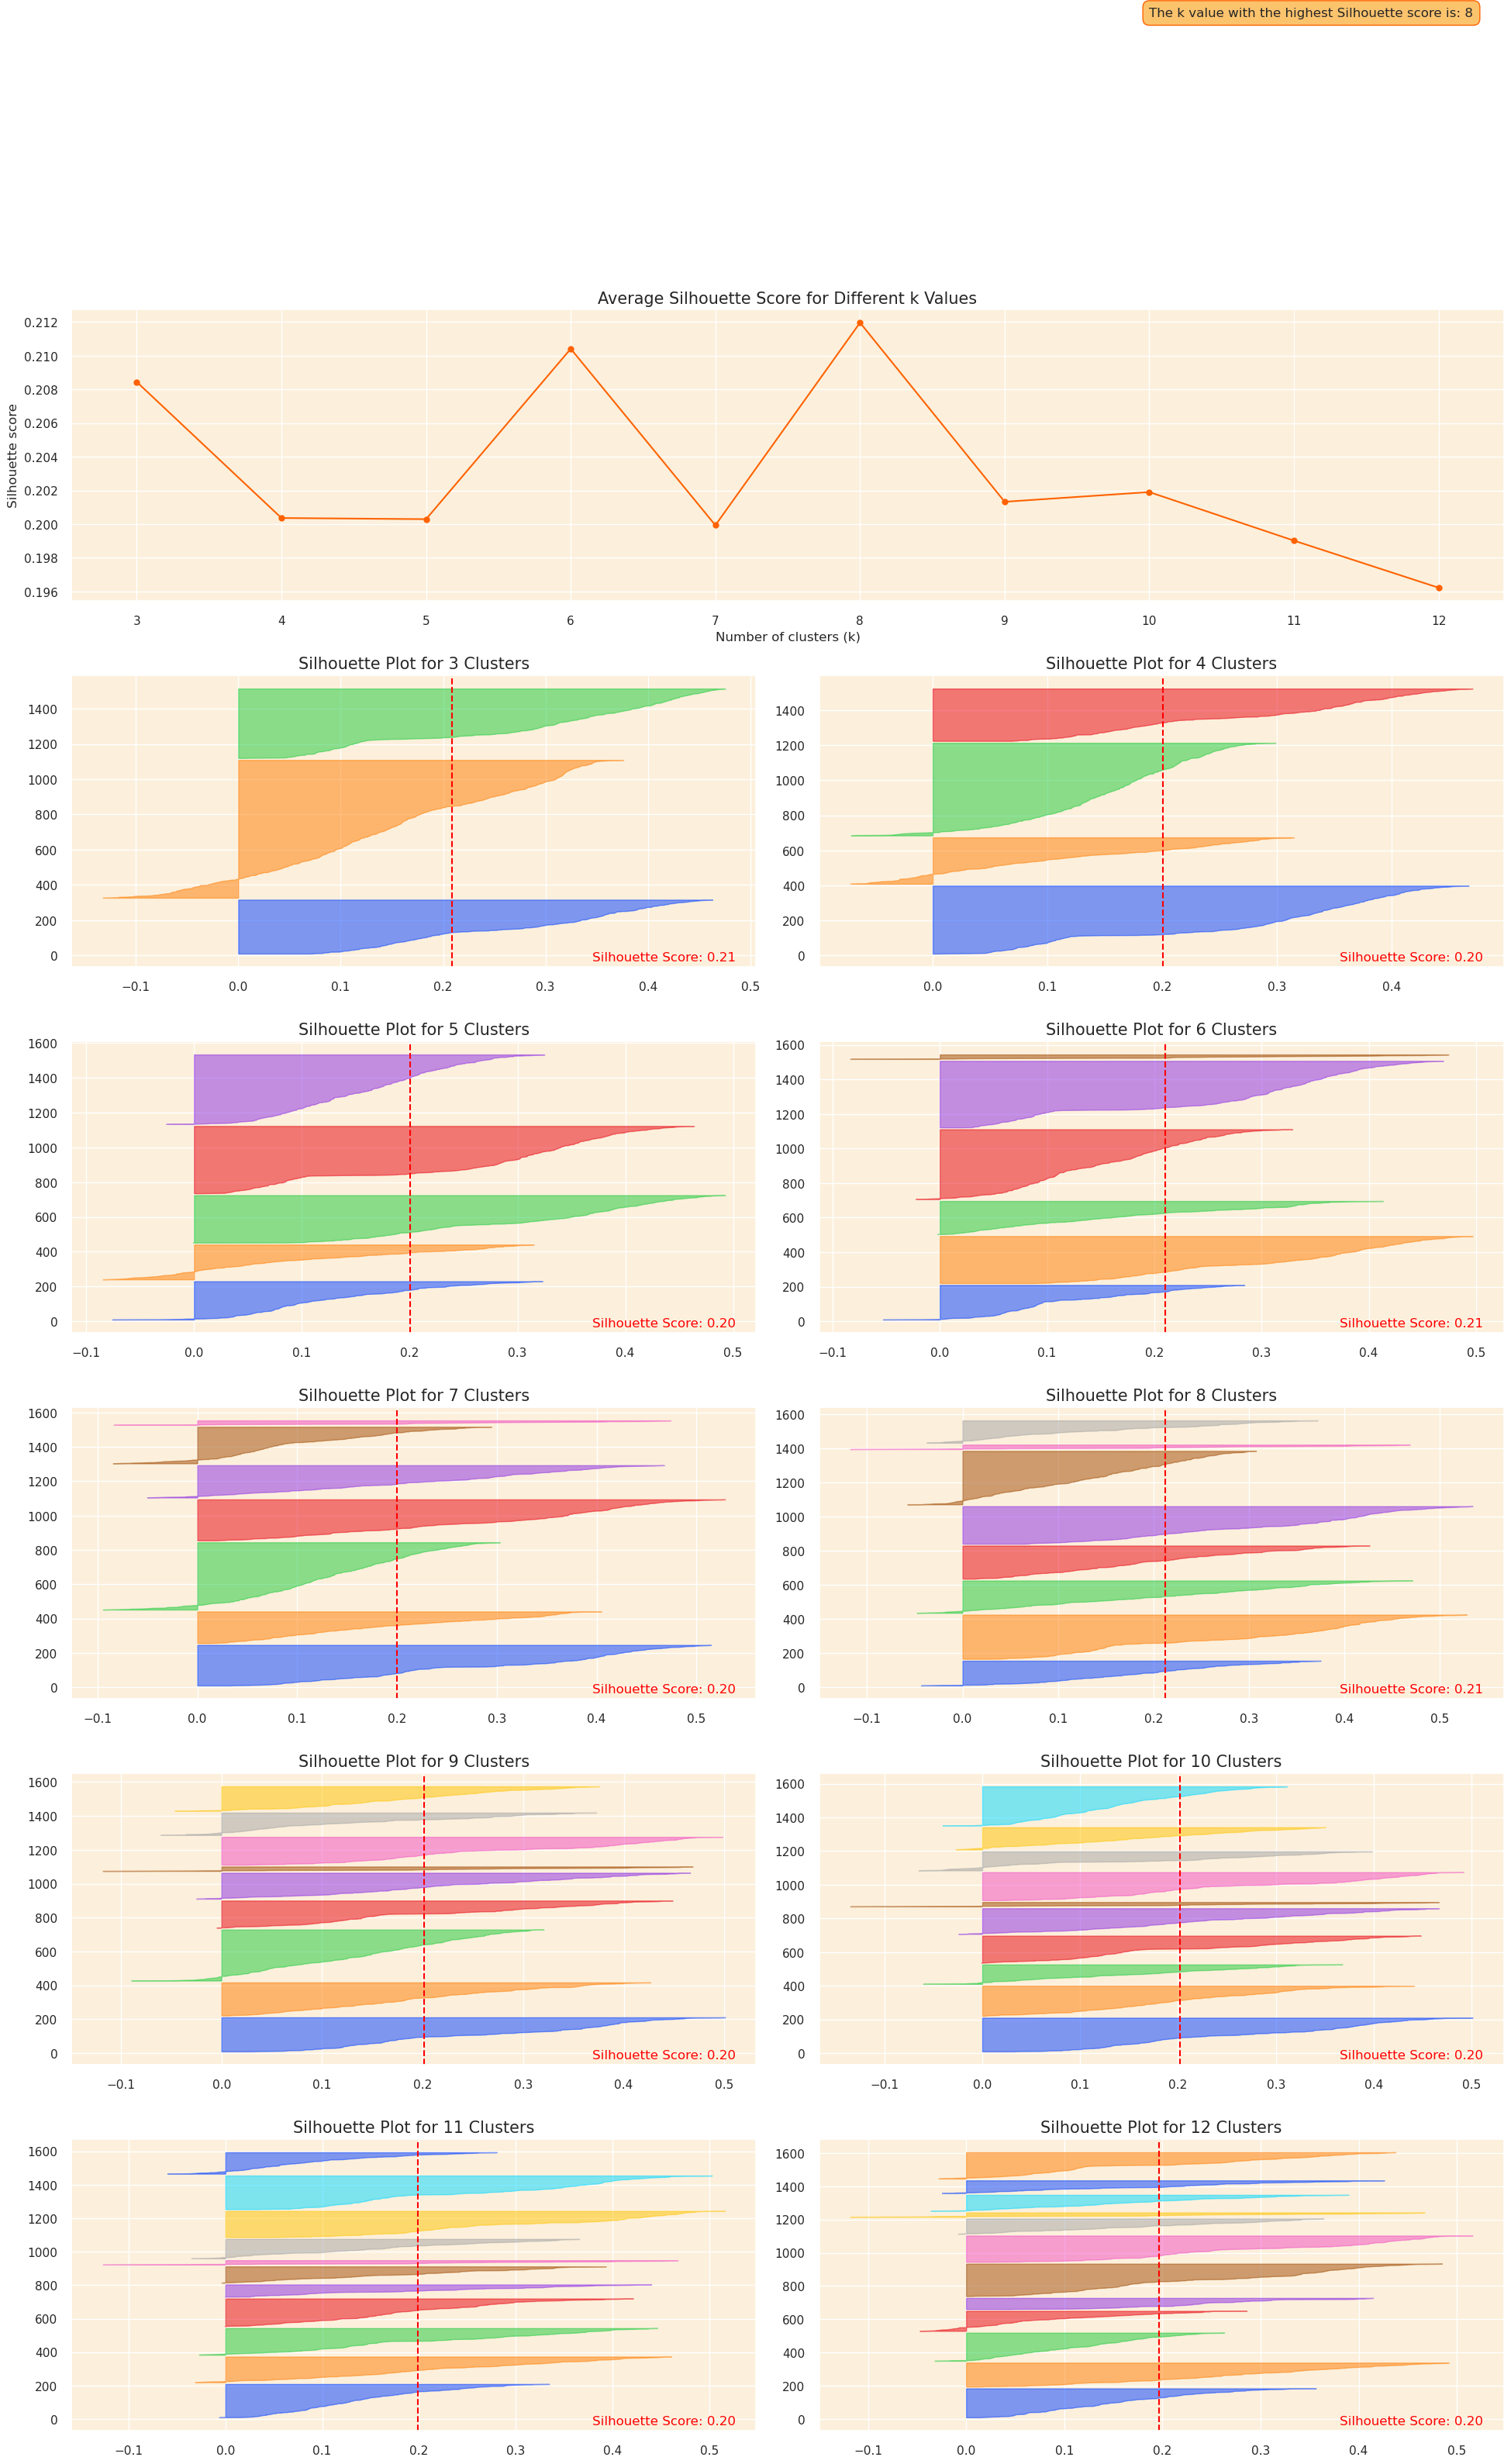

In [677]:
silhouette_analysis(customer_data_numeric_imputed, 3, 12, figsize=(20, 50))

### Clustering com k-means

In [678]:
# Apply KMeans clustering with 7 clusters
kmeans = KMeans(n_clusters=7, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(customer_data_numeric_imputed)

# Get the frequency of each cluster
cluster_frequencies = Counter(kmeans.labels_)

# Create a mapping from old labels to new labels based on frequency (most common becomes 0, etc.)
label_mapping = {label: new_label for new_label, (label, _) in 
                 enumerate(cluster_frequencies.most_common())}

# Apply the mapping to get the new labels
new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

# Append the new cluster labels back to the original dataset
customer_data_cleaned['cluster'] = new_labels

# Append the new cluster labels to the PCA version of the dataset
customer_data_pca['cluster'] = new_labels

In [679]:
# Display the first few rows of the original dataframe
customer_data_cleaned.head()

,ClienteId,Nome,Sexo,EstadoCivil,Profissão,Concelho,Distrito,DataNascimento,Idade,PercentagemComprasOnline,...,Day_Of_Week,Hour,Single_Purchase,Favorite_Shopping_Day,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Recency_First_Purchase_Days,CategoriaFavorita,cluster
0,100,Vicente de Sá,Masculino,Solteiro,Carpinteiro,Sabugal,Guarda,1988-08-31,36,100.0,...,2,12,True,Wednesday,852.2136,-1.0,-1.0,1142,Perifericos,4
1,102,Yasmin Henriques,Feminino,Divorciado,Estudante,Vizela,Braga,2006-08-09,18,100.0,...,3,12,True,Thursday,354.0696,-1.0,-1.0,1043,Perifericos,2
2,103,Micael Almeida,Masculino,Casado,Contabilista,Sertã,Castelo Branco,2002-12-10,22,100.0,...,3,12,False,Thursday,797.5982,56.686523,-3.8781,1077,Smartphones,5
3,104,Nuno de Branco,Masculino,Solteiro,Gestor de Projetos,Porto,Porto,1954-01-08,71,100.0,...,2,12,False,Wednesday,765.533433,178.464811,-121.8208,536,Perifericos,5
4,105,Fernando Costa-Costa,Masculino,Solteiro,Aposentado,Braga,Braga,1973-10-20,51,100.0,...,0,12,True,Monday,1089.9825,-1.0,-1.0,1221,Perifericos,4


## Avaliação dos clusters

In [680]:
# Setting up the color scheme for the clusters (RGB order)
colors = ['#e8000b', '#1ac938', '#023eff']

In [681]:
colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA', '#FFA15A', '#19D3F3', '#FF6692']

fig = go.Figure()

for i in range(7):
    cluster_data = customer_data_pca[customer_data_pca['cluster'] == i]
    fig.add_trace(go.Scatter3d(
        x=cluster_data['PC1'], 
        y=cluster_data['PC2'], 
        z=cluster_data['PC3'],
        mode='markers',
        marker=dict(color=colors[i], size=5, opacity=0.4),
        name=f'Cluster {i}'
    ))

fig.update_layout(
    title=dict(text='3D Visualization of Customer Clusters in PCA Space', x=0.5),
    scene=dict(
        xaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC1'),
        yaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC2'),
        zaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC3'),
    ),
    width=900,
    height=800
)

fig.show()

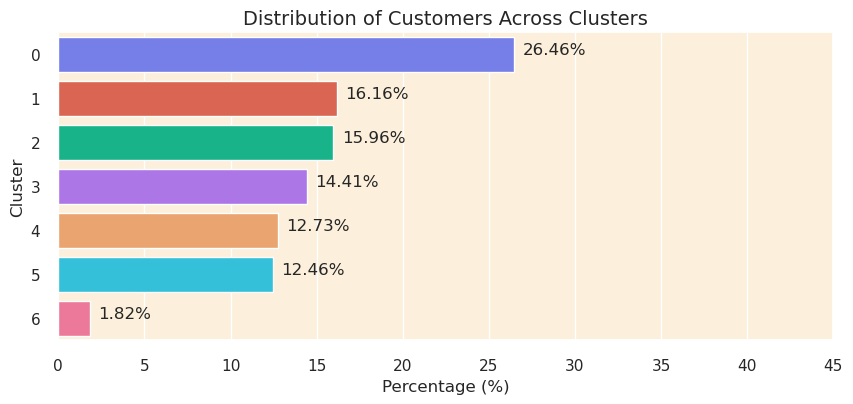

In [682]:
# Calculate the percentage of customers in each cluster
cluster_percentage = (customer_data_pca['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

# Create a horizontal bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)

# Adding percentages on the bars
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

# Show the plot
plt.show()

In [683]:
# Compute number of customers
num_observations = len(customer_data_pca)

# Separate the features and the cluster labels
X = customer_data_pca.drop('cluster', axis=1)
clusters = customer_data_pca['cluster']

# Compute the metrics
sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)

# Create a table to display the metrics and the number of observations
table_data = [
    ["Number of Observations", num_observations],
    ["Silhouette Score", sil_score],
    ["Calinski Harabasz Score", calinski_score],
    ["Davies Bouldin Score", davies_score]
]

# Print the table
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt='pretty'))

+-------------------------+---------------------+
|         Metric          |        Value        |
+-------------------------+---------------------+
| Number of Observations  |        1485         |
|    Silhouette Score     | 0.22615751516884366 |
| Calinski Harabasz Score | 426.30997993581184  |
|  Davies Bouldin Score   | 1.2740733395778638  |
+-------------------------+---------------------+


## Profiling

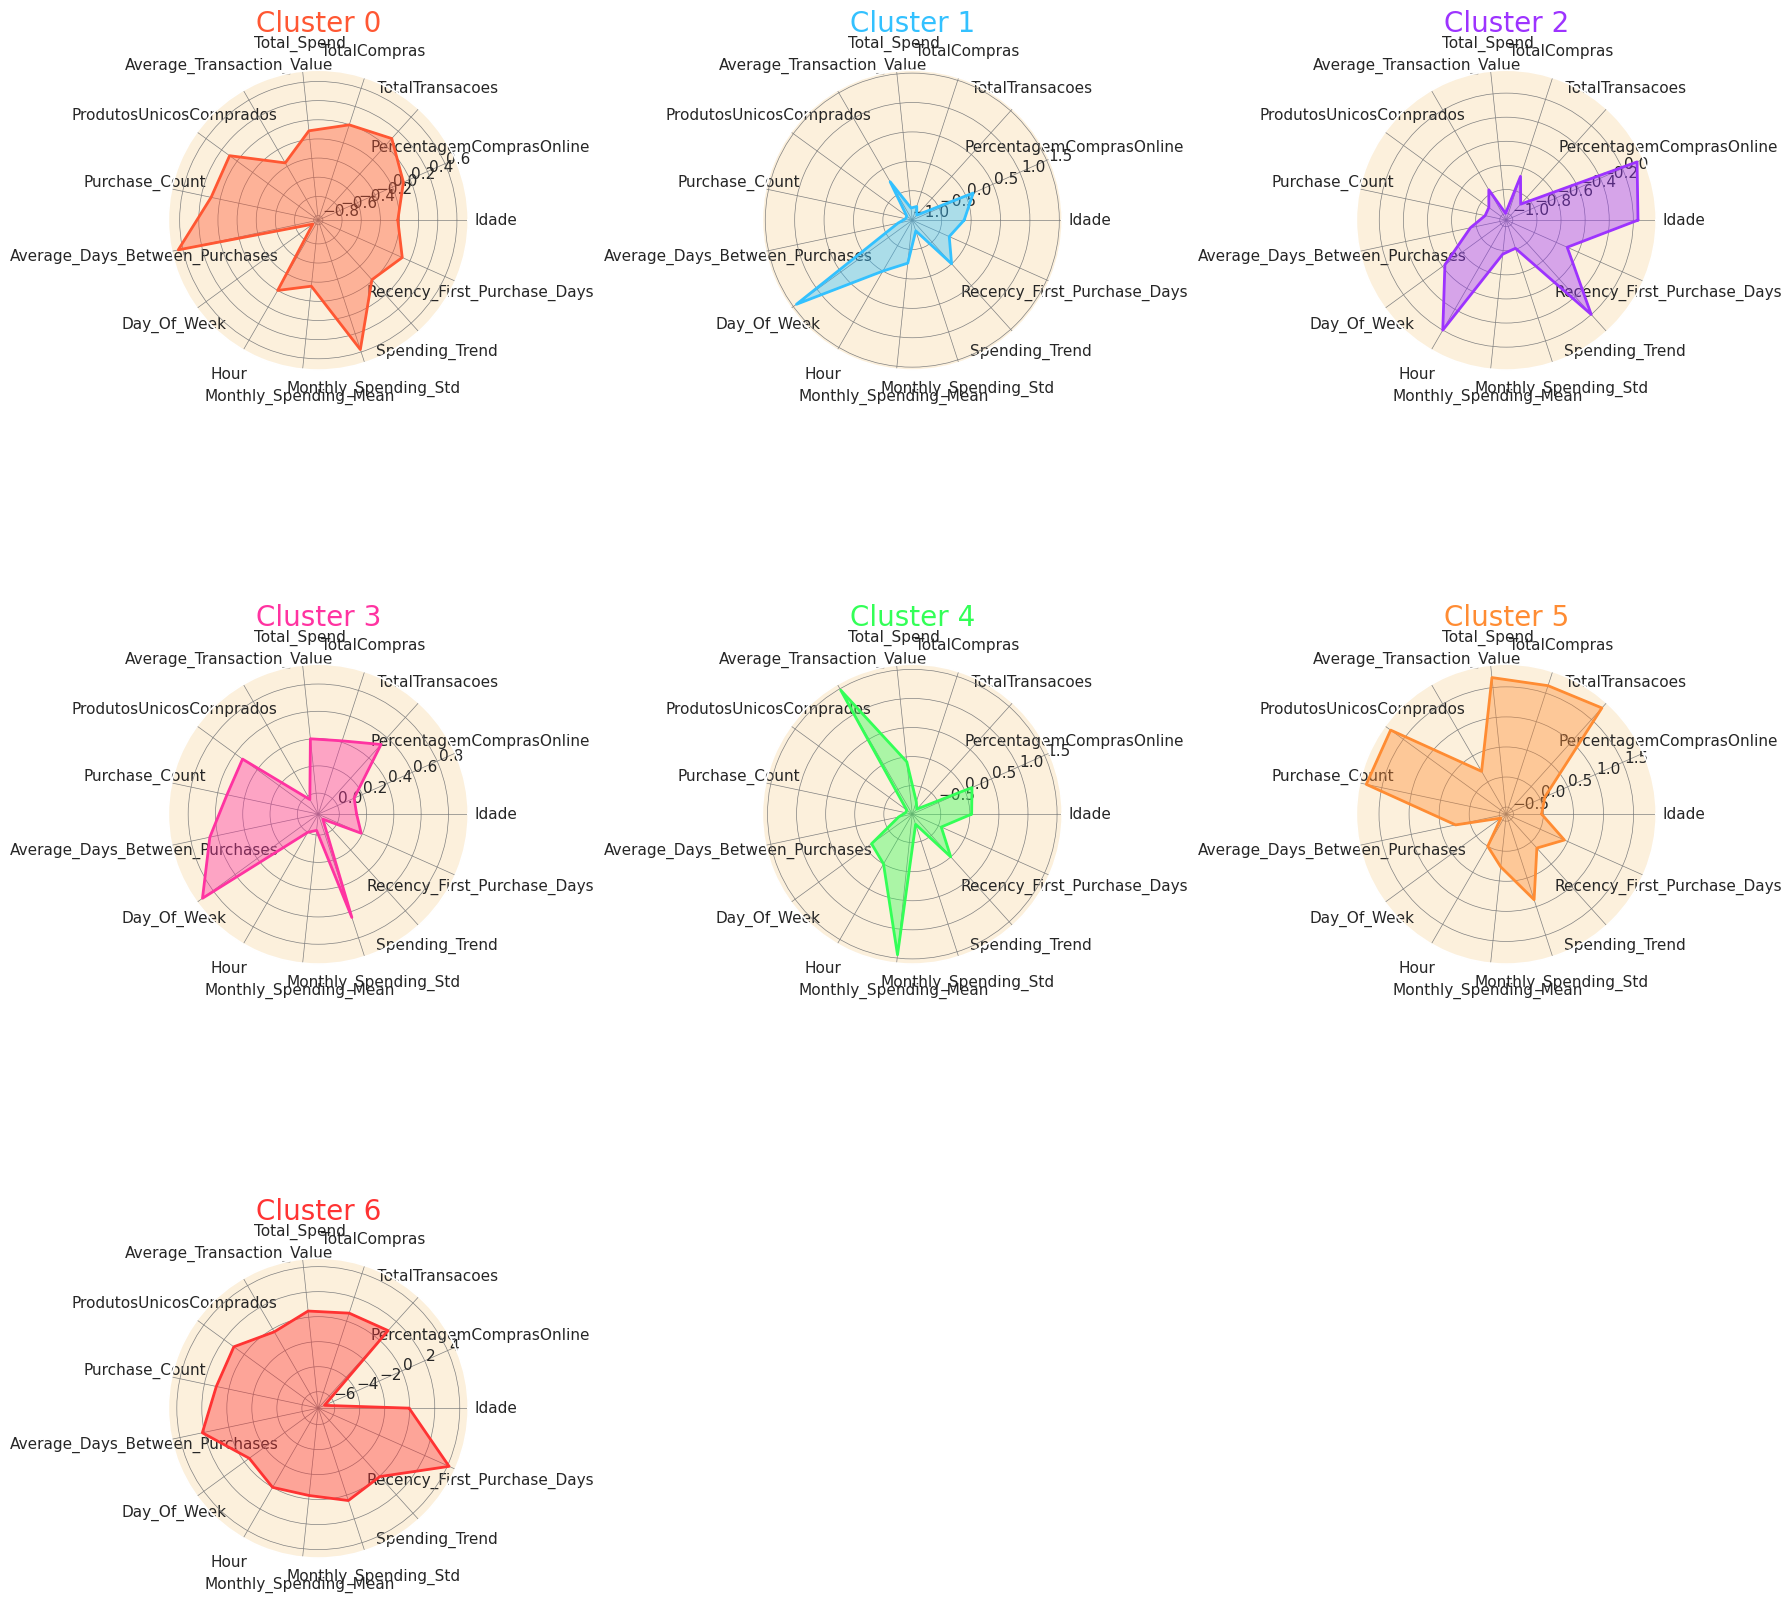

In [684]:
df_customer = customer_data_cleaned.set_index('ClienteId')

# Keep only numeric columns for scaling (excluding 'cluster')
numeric_cols = df_customer.select_dtypes(include=np.number).drop(columns=['cluster'])

# Standardize the numeric data
scaler = StandardScaler()
standardized_values = scaler.fit_transform(numeric_cols)

# Create a DataFrame with standardized values
df_customer_standardized = pd.DataFrame(
    standardized_values,
    columns=numeric_cols.columns,
    index=df_customer.index
)

# Add the 'cluster' column back
df_customer_standardized['cluster'] = df_customer['cluster']

# Calculate the centroids of each cluster
cluster_centroids = df_customer_standardized.groupby('cluster').mean()

# Function to create a radar chart
def create_radar_chart(ax, angles, data, color, cluster):
    # Plot and fill
    ax.fill(angles, data, color=color, alpha=0.4)
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')
    ax.set_title(f'Cluster {cluster}', size=20, color=color, y=1.1)

# Labels and number of variables
labels = np.array(cluster_centroids.columns)
num_vars = len(labels)

# Compute angles for radar chart
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Complete the loop for circular radar
labels = np.concatenate((labels, [labels[0]]))
angles += angles[:1]

colors = ['#FF5733', '#33C1FF', '#9D33FF', '#FF33A1', '#33FF57', '#FF8C33', '#FF3333'] 

n_clusters = 7
nrows = 3
ncols = 3

fig, axs = plt.subplots(figsize=(6 * ncols, 6 * nrows), 
                        subplot_kw=dict(polar=True), 
                        nrows=nrows, 
                        ncols=ncols)

axs = axs.flatten() 

for i in range(n_clusters):
    data = cluster_centroids.loc[i].tolist()
    data += data[:1]
    create_radar_chart(axs[i], angles, data, colors[i], i)

    axs[i].set_xticks(angles[:-1])
    axs[i].set_xticklabels(labels[:-1])
    axs[i].grid(color='grey', linewidth=0.5)

for j in range(n_clusters, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


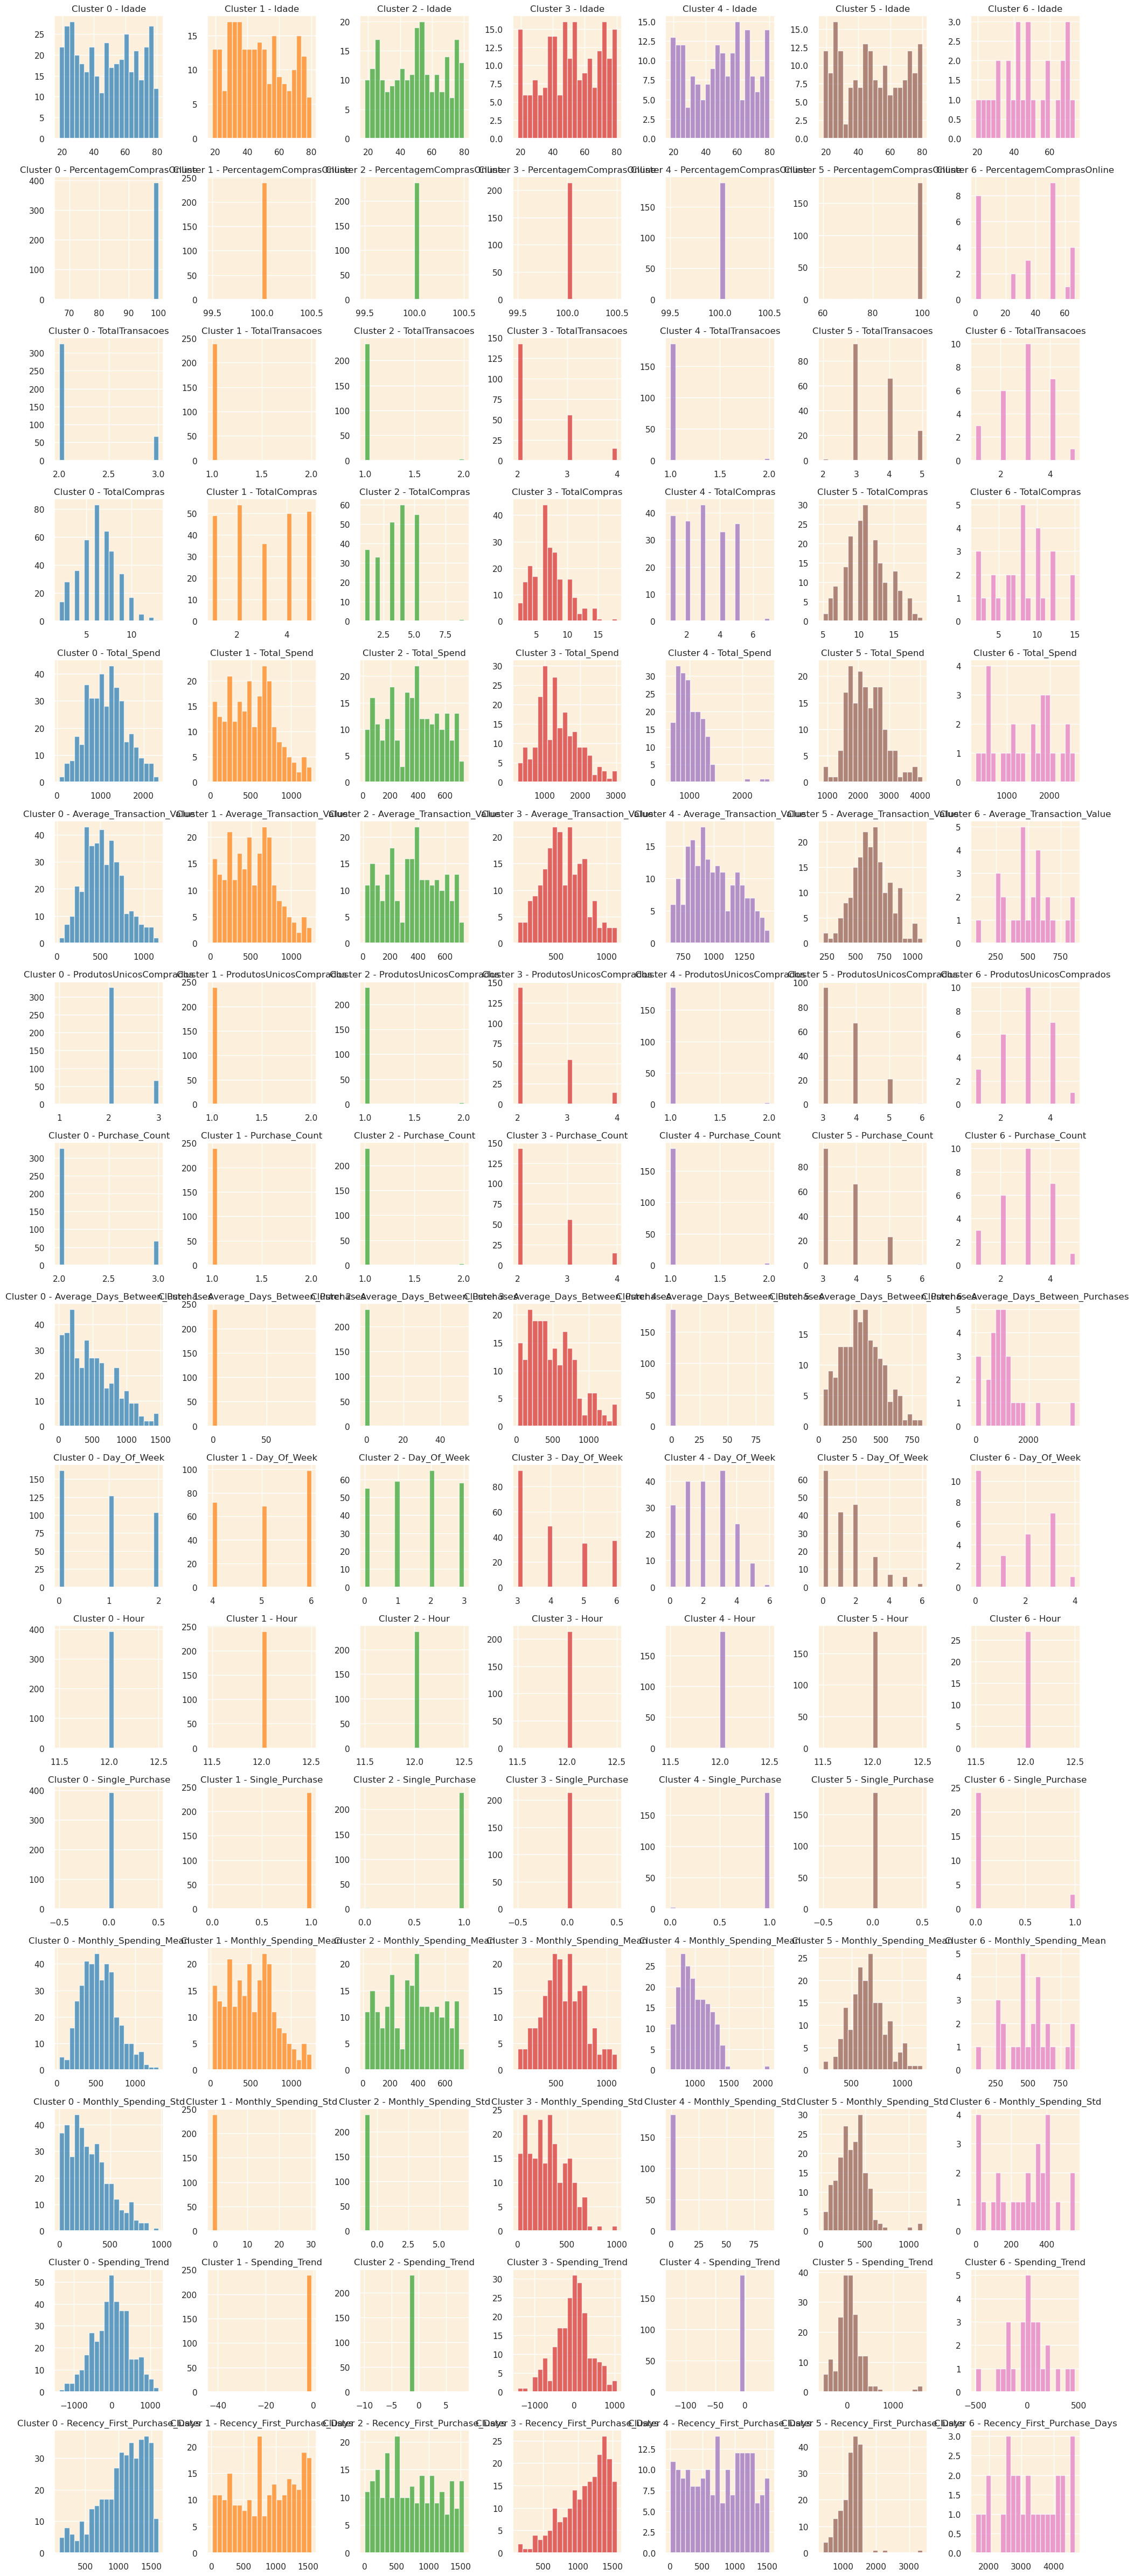

In [685]:
import matplotlib.cm as cm
import numpy as np

features = customer_data_cleaned.drop(
    columns=['ClienteId', 'cluster', 'Nome', 'Sexo', 'EstadoCivil', 'Profissão', 'Concelho', 'Distrito', 'DataNascimento', 'Favorite_Shopping_Day', 'CategoriaFavorita']
).columns

clusters = np.sort(customer_data_cleaned['cluster'].unique())
n_clusters = len(clusters)

# Setup color palette
colors = cm.tab10.colors[:n_clusters]

# Setup subplots
n_rows = len(features)
n_cols = n_clusters
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3 * n_rows))
axes = np.atleast_2d(axes)  # Ensure 2D indexing works

# Plot histograms
for i, feature in enumerate(features):
    for j, cluster in enumerate(clusters):
        data = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster][feature]

        # Handle data types
        if pd.api.types.is_bool_dtype(data):
            data_clean = data.dropna().astype(int)  # Convert bool to 0/1
        elif pd.api.types.is_numeric_dtype(data):
            data_clean = data.dropna()
        else:
            data_clean = None

        # Plot or show message
        if data_clean is not None and len(data_clean) > 0:
            axes[i, j].hist(data_clean, bins=20, color=colors[j], edgecolor='w', alpha=0.7)
        elif data_clean is not None:
            axes[i, j].text(0.5, 0.5, "No valid data", 
                            horizontalalignment='center',
                            verticalalignment='center',
                            transform=axes[i, j].transAxes)
        else:
            axes[i, j].text(0.5, 0.5, f"Non-numeric feature: {feature}", 
                            horizontalalignment='center',
                            verticalalignment='center',
                            transform=axes[i, j].transAxes)

        axes[i, j].set_title(f'Cluster {cluster} - {feature}', fontsize=12)
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

# Tidy up layout
plt.tight_layout()
plt.show()


# **Sistemas de recomendação**

## Demographic filetering
Recomendação da trend de vendas para clientes novos sem dados

In [686]:
# Determinar a data da compra mais antiga
df_vendas['DataId'] = pd.to_datetime(df_vendas['DataId'])

data_compra_mais_antiga = df_vendas['DataId'].min()

print(f"A compra mais antiga foi em: {data_compra_mais_antiga.date()}")

A compra mais antiga foi em: 2010-01-15


In [687]:
hoje = datetime.now()
um_mes_atras = hoje - timedelta(days=365)

vendas_ultimo_mes = df_vendas[df_vendas['DataId'] >= um_mes_atras]

contagem_produtos = vendas_ultimo_mes['ProdutoId'].value_counts().reset_index()
contagem_produtos.columns = ['ProdutoId', 'NumeroVendas']

top_produtos = contagem_produtos.merge(df_produtos, on='ProdutoId', how='left')

top_30_produtos = top_produtos.head(30)

top_30_produtos


,ProdutoId,NumeroVendas,Nome,Marca,Categoria
0,81,8,Rato ASUS ROG Chakram,ASUS,Perifericos
1,98,7,"Monitor 32 Samsung Odyssey G5""",Samsung,Monitores
2,31,7,Rato Logitech G502,Logitech,Perifericos
3,109,7,Headset HyperX Cloud Alpha,HyperX,Audio
4,136,7,Webcam Razer Kiyo Pro,Razer,Perifericos
5,174,7,Headset Sennheiser HD 560S,Sennheiser,Audio
6,84,7,Headset Sony WH-CH710N,Sony,Audio
7,15,7,Smartphone Xiaomi Redmi Note 9,Xiaomi,Smartphones
8,111,6,Rato Logitech G703,Logitech,Perifericos
9,52,6,Teclado Logitech K380,Logitech,Perifericos


## Content-based filtering + Collaborative filtering
Recomendações para clientes existentes com algum histórico de comprar <br>
Basear as recomendações em hábitos de compra do cliente e hábitos de compra do cluster onde o cliente está inserido

### Content-based filtering

In [688]:
# historico de compras de um dado cliente
def get_client_purchases(client_id, vendas_df):
    client_purchases = vendas_df[vendas_df['ClienteId'] == client_id]['ProdutoId'].unique()
    return client_purchases

In [689]:
from sklearn.metrics.pairwise import cosine_similarity

# recomendar produtos
def recommend_products(client_id, vendas_df, produtos_df, top_n=10):
    # Get the client's purchase history
    purchased_products = get_client_purchases(client_id, vendas_df)
    
    if len(purchased_products) == 0:
        return "No purchase history for this client."
    
    # Create one-hot encoding for product categories and brands
    produtos_encoded = pd.get_dummies(produtos_df[['Categoria', 'Marca']])
    
    # Calculate the profile of purchased products
    client_profile = produtos_encoded.loc[produtos_df['ProdutoId'].isin(purchased_products)].mean(axis=0)
    
    # Calculate similarity between client profile and all products
    similarity_scores = []
    for idx, row in produtos_encoded.iterrows():
        sim_score = cosine_similarity([client_profile], [row])[0][0]
        similarity_scores.append((produtos_df.loc[idx, 'ProdutoId'], produtos_df.loc[idx, 'Nome'], sim_score))
    
    # Sort by similarity and filter out already purchased products
    similarity_scores.sort(key=lambda x: x[2], reverse=True)
    recommendations = [(prod_id, name) for prod_id, name, _ in similarity_scores 
                      if prod_id not in purchased_products]
    
    return recommendations[:top_n]

In [690]:
example_customer_id = customer_data_cleaned['ClienteId'].iloc[0]
recomendations = recommend_products(example_customer_id, df_vendas, df_produtos, top_n=10)

print(f"\n----- CONTENT-BASED RECOMMENDATIONS FOR CLIENT {example_customer_id} -----")

df_recommendations = pd.DataFrame(recomendations, columns=['ProdutoId', 'Nome'])
display(df_recommendations)


----- CONTENT-BASED RECOMMENDATIONS FOR CLIENT 100 -----


,ProdutoId,Nome
0,4,Teclado Gaming Razer BlackWidow
1,11,Rato Razer DeathAdder
2,32,Teclado Razer Huntsman
3,41,Rato Razer Viper
4,62,Teclado Razer Ornata V2
5,71,Webcam Razer Kiyo
6,106,Rato Razer Basilisk V3
7,132,Teclado Gaming Razer Cynosa V2
8,136,Webcam Razer Kiyo Pro
9,146,Rato Razer Naga Pro


### Collaborative filtering

In [691]:
df_with_clusters = df_vendas.merge(customer_data_cleaned[['ClienteId', 'cluster']], on='ClienteId', how='inner')

# Create a product purchase matrix: customers x products with purchase frequency
purchase_matrix = pd.crosstab(df_with_clusters['ClienteId'], df_with_clusters['ProdutoId'])

# Let's analyze product popularity by cluster
cluster_product_popularity = {}

for cluster_id in range(7):
    # Get customers in this cluster
    cluster_customers = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster_id]['ClienteId']
    
    # Filter transactions for this cluster
    cluster_transactions = df_with_clusters[df_with_clusters['cluster'] == cluster_id]
    
    # Calculate product popularity within this cluster
    product_counts = cluster_transactions.groupby('ProdutoId').agg(
        purchase_count=('VendaId', 'nunique'),
        customer_count=('ClienteId', 'nunique'),
        total_quantity=('Quantidade', 'sum'),
        total_revenue=('Total_Spend', 'sum')
    )
    
    # Calculate penetration rate (% of cluster customers who bought this product)
    cluster_customer_count = cluster_customers.nunique()
    product_counts['penetration_rate'] = product_counts['customer_count'] / cluster_customer_count * 100
    
    # Sort by popularity metrics
    popular_products = product_counts.sort_values(by=['penetration_rate', 'total_revenue'], ascending=False)
    
    # Store the results
    cluster_product_popularity[cluster_id] = popular_products

In [692]:
df_vendas = pd.merge(df_vendas, df_produtos, on='ProdutoId')

In [693]:
# Function to get top product recommendations for each cluster
def get_cluster_recommendations(cluster_id, top_n=10):
    popular_products = cluster_product_popularity[cluster_id].head(top_n)
    
    # Get product descriptions
    product_info = df_vendas[['ProdutoId', 'Nome']].drop_duplicates()
    recommendations = popular_products.reset_index().merge(
        product_info, on='ProdutoId', how='left'
    )
    
    return recommendations[['ProdutoId', 'Nome', 'purchase_count', 
                           'customer_count', 'penetration_rate', 
                           'total_quantity', 'total_revenue']]

In [694]:
for cluster_id in range(7):
    print(f"\n----- TOP PRODUCT RECOMMENDATIONS FOR CLUSTER {cluster_id} -----")
    cluster_recs = get_cluster_recommendations(cluster_id, top_n=10)

    cluster_recs['penetration_rate'] = cluster_recs['penetration_rate'].map('{:.2f}'.format)
    cluster_recs['total_revenue'] = cluster_recs['total_revenue'].map('{:.2f}'.format)

    display(cluster_recs.reset_index(drop=True))


----- TOP PRODUCT RECOMMENDATIONS FOR CLUSTER 0 -----


,ProdutoId,Nome,purchase_count,customer_count,penetration_rate,total_quantity,total_revenue
0,12,Teclado Logitech G Pro,11,11,2.80,35,6385.33
1,157,Teclado Corsair Strafe RGB,10,10,2.54,29,6725.96
2,126,Rato HyperX Pulsefire Haste,10,10,2.54,29,6095.24
3,30,Smartphone Samsung Galaxy A51,10,10,2.54,25,5317.59
4,37,Teclado Corsair K55,10,10,2.54,24,4802.14
5,151,Rato SteelSeries Prime,9,9,2.29,21,6956.44
6,172,Teclado Razer Pro Type,9,9,2.29,25,5904.79
7,139,Impressora Epson WorkForce WF-110,9,9,2.29,24,5022.77
8,25,Smartphone Google Pixel 4,9,9,2.29,28,4662.69
9,78,"Monitor 34 LG UltraWide""",9,9,2.29,21,3608.26



----- TOP PRODUCT RECOMMENDATIONS FOR CLUSTER 1 -----


,ProdutoId,Nome,purchase_count,customer_count,penetration_rate,total_quantity,total_revenue
0,127,Teclado Logitech G915 TKL,5,5,2.08,19,3970.46
1,74,Impressora Epson EcoTank L3150,5,5,2.08,13,2995.60
2,113,Monitor 24 Polegadas ASUS ROG,5,5,2.08,11,2130.60
3,84,Headset Sony WH-CH710N,5,5,2.08,13,1762.39
4,38,"Monitor 22 AOC""",4,4,1.67,15,3033.34
5,172,Teclado Razer Pro Type,4,4,1.67,12,2699.86
6,63,Monitor 24 Polegadas HP,4,4,1.67,16,2636.10
7,120,Smartwatch Garmin Forerunner 245,4,4,1.67,8,2376.18
8,111,Rato Logitech G703,4,4,1.67,14,2215.60
9,35,Smartphone iPhone 12,4,4,1.67,16,2213.86



----- TOP PRODUCT RECOMMENDATIONS FOR CLUSTER 2 -----


,ProdutoId,Nome,purchase_count,customer_count,penetration_rate,total_quantity,total_revenue
0,94,Headset JBL Live 650BTNC,6,6,2.53,21,2560.74
1,28,"Monitor Dell UltraSharp 27"",Dell,Monitores\n29...",4,4,1.69,7,1948.15
2,161,Rato Razer Orochi V2,4,4,1.69,12,1481.02
3,84,Headset Sony WH-CH710N,4,4,1.69,8,1471.21
4,101,Webcam Microsoft LifeCam HD,4,4,1.69,15,1406.47
5,17,Teclado Mecânico Ducky One 2,4,4,1.69,17,1286.09
6,16,Rato Corsair Dark Core,4,4,1.69,12,1210.96
7,42,Teclado Mecânico Redragon K552,4,4,1.69,14,1107.67
8,10,Smartphone Apple iPhone 11,3,3,1.27,9,1828.12
9,1,Rato Logitech MX Master,3,3,1.27,12,1735.44



----- TOP PRODUCT RECOMMENDATIONS FOR CLUSTER 3 -----


,ProdutoId,Nome,purchase_count,customer_count,penetration_rate,total_quantity,total_revenue
0,106,Rato Razer Basilisk V3,9,9,4.21,27,4721.95
1,112,Teclado Gaming G.Skill Ripjaws KM570,8,8,3.74,21,4130.79
2,11,Rato Razer DeathAdder,7,7,3.27,23,5270.19
3,4,Teclado Gaming Razer BlackWidow,7,7,3.27,23,4654.21
4,72,Placa Gráfica ASUS RTX 3070,7,7,3.27,26,4488.57
5,49,Headset HyperX Cloud Stinger,7,7,3.27,13,3437.18
6,115,Smartphone iPhone 14,6,6,2.80,19,5263.91
7,56,Rato HyperX Pulsefire Dart,6,6,2.80,19,4174.26
8,113,Monitor 24 Polegadas ASUS ROG,6,6,2.80,15,3570.43
9,26,Rato HyperX Pulsefire,6,6,2.80,16,3144.16



----- TOP PRODUCT RECOMMENDATIONS FOR CLUSTER 4 -----


,ProdutoId,Nome,purchase_count,customer_count,penetration_rate,total_quantity,total_revenue
0,59,Headset Corsair HS60,4,4,2.12,16,3545.97
1,171,Rato SteelSeries Rival 5,4,4,2.12,12,3273.58
2,60,Smartphone Google Pixel 5,4,4,2.12,12,3179.27
3,162,Teclado Ducky Mecha Mini,3,3,1.59,7,3934.82
4,147,Teclado Gaming Keychron K4,3,3,1.59,6,3716.25
5,38,"Monitor 22 AOC""",3,3,1.59,6,3583.82
6,44,Headset Logitech G Pro X,3,3,1.59,11,3358.19
7,61,Rato Logitech G305,3,3,1.59,11,3323.49
8,30,Smartphone Samsung Galaxy A51,3,3,1.59,9,3313.50
9,146,Rato Razer Naga Pro,3,3,1.59,9,3231.54



----- TOP PRODUCT RECOMMENDATIONS FOR CLUSTER 5 -----


,ProdutoId,Nome,purchase_count,customer_count,penetration_rate,total_quantity,total_revenue
0,54,Headset Razer BlackShark V2,12,12,6.49,46,5643.36
1,174,Headset Sennheiser HD 560S,11,11,5.95,30,5832.44
2,6,NaN,10,10,5.41,31,4613.49
3,128,"Monitor 32 HP Omen""",9,9,4.86,26,3252.86
4,77,Teclado Mecânico Kinesis Freestyle,8,8,4.32,24,6020.62
5,7,Headset Gamer HyperX Cloud,8,8,4.32,26,5761.77
6,35,Smartphone iPhone 12,8,8,4.32,21,5735.10
7,136,Webcam Razer Kiyo Pro,8,8,4.32,19,5302.53
8,99,Headset SteelSeries Arctis 9,8,8,4.32,27,4869.47
9,168,"Monitor 27 LG UltraFine""",7,7,3.78,20,5728.23



----- TOP PRODUCT RECOMMENDATIONS FOR CLUSTER 6 -----


,ProdutoId,Nome,purchase_count,customer_count,penetration_rate,total_quantity,total_revenue
0,111,Rato Logitech G703,3,3,11.11,9,1833.70
1,144,Headset JBL Quantum 400,3,3,11.11,8,1766.24
2,10,Smartphone Apple iPhone 11,3,3,11.11,6,1507.60
3,108,"Monitor 27 Dell Alienware""",3,3,11.11,6,1378.91
4,34,Headset SteelSeries Siberia,3,3,11.11,7,1070.49
5,80,Smartphone OnePlus 9,3,3,11.11,9,909.57
6,40,Smartphone Samsung Galaxy S20,3,3,11.11,9,727.53
7,96,Rato Corsair Scimitar,2,2,7.41,8,1519.70
8,97,Teclado Gaming Anne Pro 2,2,2,7.41,4,1508.00
9,152,Teclado Logitech K780,2,2,7.41,5,1307.01


In [695]:
def get_customer_recommendations(customer_id, n_recommendations=5):
    try:
        customer_cluster = customer_data_cleaned[
            customer_data_cleaned['ClienteId'] == customer_id
        ]['cluster'].values[0]
    except IndexError:
        return "Customer not found in the cluster data."

    # Verifica se o cluster existe no dicionário
    if customer_cluster not in cluster_product_popularity:
        return f"No product popularity data for cluster {customer_cluster}."

    customer_purchases = df_vendas[df_vendas['ClienteId'] == customer_id]['ProdutoId'].unique()
    cluster_popular = cluster_product_popularity[customer_cluster]

    new_recommendations = cluster_popular[
        ~cluster_popular.index.isin(customer_purchases)
    ].head(n_recommendations)

    product_info = df_vendas[['ProdutoId', 'Nome']].drop_duplicates()
    recommendations = new_recommendations.reset_index().merge(
        product_info, on='ProdutoId', how='left'
    )

    return recommendations[['ProdutoId', 'Nome', 'penetration_rate', 'total_revenue']]


In [696]:
print(f"\n----- PERSONALIZED RECOMMENDATIONS FOR CUSTOMER {example_customer_id} -----")
customer_recs = get_customer_recommendations(example_customer_id, n_recommendations=10)

# Verifica se o retorno é um DataFrame
if isinstance(customer_recs, pd.DataFrame) and not customer_recs.empty:
    customer_recs['penetration_rate'] = customer_recs['penetration_rate'].map('{:.2f}'.format)
    customer_recs['total_revenue'] = customer_recs['total_revenue'].map('{:.2f}'.format)
    display(customer_recs.reset_index(drop=True))
else:
    print(customer_recs)  # Mostra mensagem_


----- PERSONALIZED RECOMMENDATIONS FOR CUSTOMER 100 -----


,ProdutoId,Nome,penetration_rate,total_revenue
0,59,Headset Corsair HS60,2.12,3545.97
1,171,Rato SteelSeries Rival 5,2.12,3273.58
2,60,Smartphone Google Pixel 5,2.12,3179.27
3,162,Teclado Ducky Mecha Mini,1.59,3934.82
4,147,Teclado Gaming Keychron K4,1.59,3716.25
5,38,"Monitor 22 AOC""",1.59,3583.82
6,44,Headset Logitech G Pro X,1.59,3358.19
7,61,Rato Logitech G305,1.59,3323.49
8,30,Smartphone Samsung Galaxy A51,1.59,3313.50
9,146,Rato Razer Naga Pro,1.59,3231.54



----- PRODUCTS WITH UNIVERSAL APPEAL ACROSS ALL CLUSTERS -----
No products with universal appeal found.


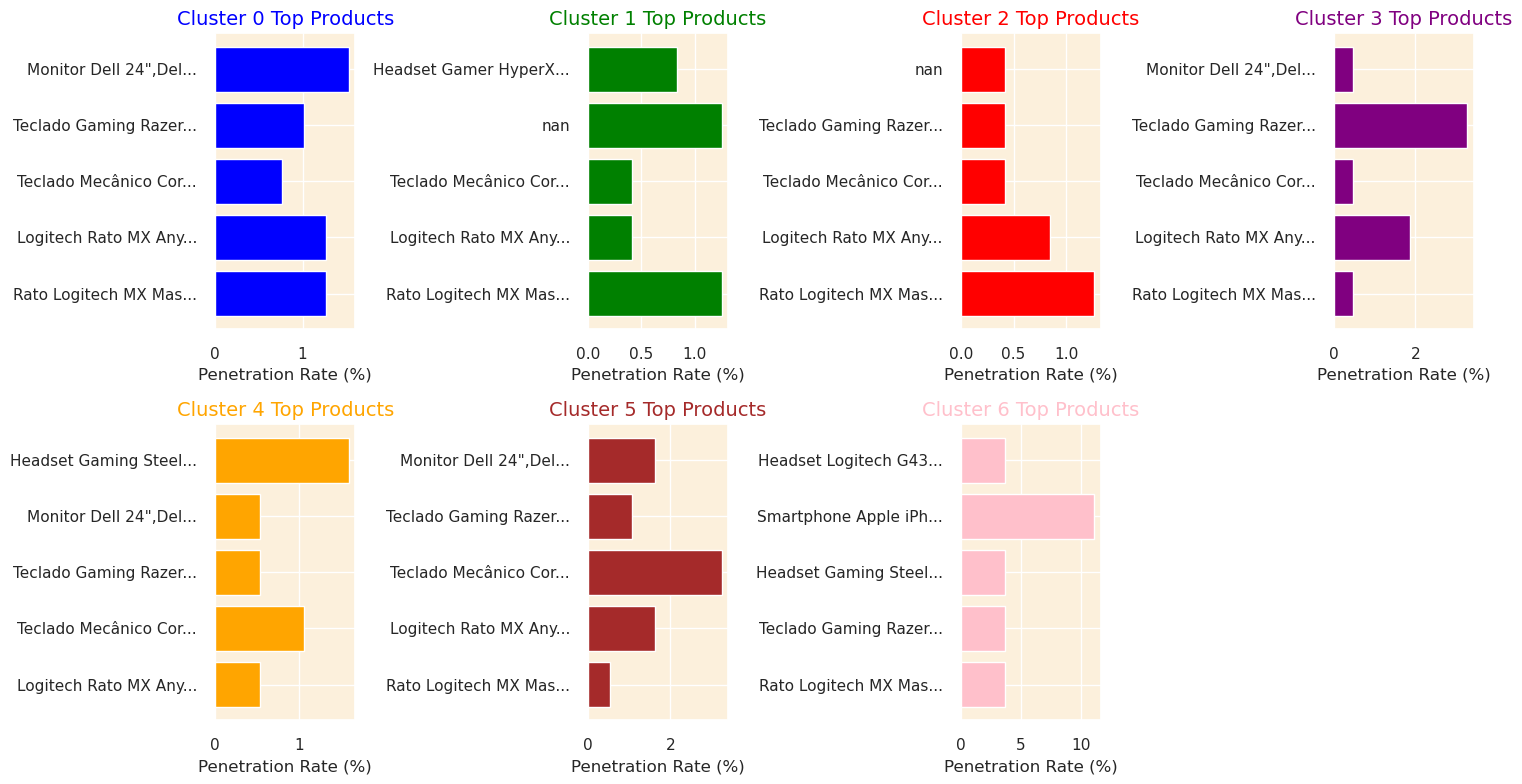


----- CLUSTER PROFILES FOR MARKETING RECOMMENDATIONS -----

CLUSTER 0 PROFILE:
Size: 393 customers (26.46% of total)
Average transactions per customer: 2.17
Average total spend: $1137.48
Average transaction value: $532.76
Average Age: 48.46
Average online purchases percentage: 99.92
Top product categories:
  - Teclado Logitech G Pro (Penetration: 2.80%)
  - Teclado Corsair Strafe RGB (Penetration: 2.54%)
  - Rato HyperX Pulsefire Haste (Penetration: 2.54%)

CLUSTER 1 PROFILE:
Size: 240 customers (16.16% of total)
Average transactions per customer: 1.00
Average total spend: $508.90
Average transaction value: $507.47
Average Age: 46.62
Average online purchases percentage: 100.00
Top product categories:
  - Teclado Logitech G915 TKL (Penetration: 2.08%)
  - Impressora Epson EcoTank L3150 (Penetration: 2.08%)
  - Monitor 24 Polegadas ASUS ROG (Penetration: 2.08%)

CLUSTER 2 PROFILE:
Size: 237 customers (15.96% of total)
Average transactions per customer: 1.01
Average total spend: $363.17


In [697]:
# Vamos analisar as recomendações de produtos entre clusters
# Isso ajudará a identificar produtos populares em vários clusters
# e que poderiam ser bons candidatos para promoções gerais.

# Calcular a popularidade dos produtos em todos os clusters
all_product_stats = df_with_clusters.groupby('ProdutoId').agg(
    purchase_count=('VendaId', 'nunique'),
    customer_count=('ClienteId', 'nunique'),
    total_quantity=('Quantidade', 'sum'),
    total_revenue=('Total_Spend', 'sum')
)

# Calcular a popularidade dentro de cada cluster
cluster_product_matrix = {}
for cluster_id in range(7):
    cluster_txns = df_with_clusters[df_with_clusters['cluster'] == cluster_id]
    
    product_stats = cluster_txns.groupby('ProdutoId').agg(
        customer_count=('ClienteId', 'nunique')
    )
    
    cluster_size = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster_id].shape[0]
    product_stats[f'cluster_{cluster_id}_penetration'] = product_stats['customer_count'] / cluster_size * 100
    
    cluster_product_matrix[cluster_id] = product_stats

# Combinar as estatísticas específicas dos clusters
cross_cluster_stats = all_product_stats.copy()
for cluster_id in range(7):
    cross_cluster_stats = cross_cluster_stats.join(
        cluster_product_matrix[cluster_id][f'cluster_{cluster_id}_penetration'],
        how='left'
    )

# Calcular a variância da penetração entre clusters para encontrar produtos com apelo universal
cross_cluster_stats['penetration_variance'] = cross_cluster_stats[[
    f'cluster_{i}_penetration' for i in range(7)
]].var(axis=1)

# Preencher valores NaN (produtos não comprados em alguns clusters)
cross_cluster_stats = cross_cluster_stats.fillna(0)

# Identificar produtos com alta penetração em múltiplos clusters (apelo universal)
universal_products = cross_cluster_stats[
    (cross_cluster_stats['penetration_variance'] < cross_cluster_stats['penetration_variance'].quantile(0.25)) &
    (cross_cluster_stats[[f'cluster_{i}_penetration' for i in range(7)]] > 0).sum(axis=1) == 7
].sort_values(by='total_revenue', ascending=False)

# Obter descrições para os produtos com apelo universal
universal_with_desc = universal_products.reset_index().merge(
    df_vendas[['ProdutoId', 'Nome']].drop_duplicates(),
    on='ProdutoId',
    how='left'
)

if universal_with_desc.empty:
    print("\n----- PRODUCTS WITH UNIVERSAL APPEAL ACROSS ALL CLUSTERS -----")
    print("No products with universal appeal found.")
else:
    print("\n----- PRODUCTS WITH UNIVERSAL APPEAL ACROSS ALL CLUSTERS -----")
    print(universal_with_desc[['ProdutoId', 'Nome', 'customer_count', 
                            'total_revenue', 'cluster_0_penetration',
                            'cluster_1_penetration', 'cluster_2_penetration',
                            'cluster_3_penetration', 'cluster_4_penetration',
                            'cluster_5_penetration', 'cluster_6_penetration']].head(10))


# Visualizar os top produtos por cluster
plt.figure(figsize=(15, 8))

# Definir cores para os gráficos
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink']

for i, cluster_id in enumerate(range(7)):  # Agora percorrendo 7 clusters
    top_products = cluster_product_matrix[cluster_id].head(5).reset_index()
    
    # Obter as descrições dos produtos (pegar os primeiros 20 caracteres para manter o gráfico legível)
    product_info = df_vendas[['ProdutoId', 'Nome']].drop_duplicates()
    top_products = top_products.merge(product_info, on='ProdutoId', how='left')
    top_products['short_desc'] = top_products['Nome'].str[:20] + '...'  # Garantir que é string
    
    # Calcular a penetração no gráfico
    top_products['penetration_rate'] = top_products[f'cluster_{cluster_id}_penetration']
    
    # Garantir que a coluna 'short_desc' seja do tipo string
    top_products['short_desc'] = top_products['short_desc'].astype(str)
    
    plt.subplot(2, 4, i+1)  # Ajustar a disposição para 2 linhas e 4 colunas
    plt.barh(top_products['short_desc'], top_products['penetration_rate'], color=colors[i])  # Usando a cor no gráfico
    plt.title(f'Cluster {cluster_id} Top Products', fontsize=14, color=colors[i])
    plt.xlabel('Penetration Rate (%)')
    plt.tight_layout()

plt.savefig('cluster_top_products.png')
plt.show()

# Criar um resumo do perfil dos clusters para recomendações de marketing
cluster_profiles = {}

for cluster_id in range(7):
    # Obter valores médios para métricas chave neste cluster
    cluster_data = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster_id]
    
    profile = {
        'size': cluster_data.shape[0],
        'size_percentage': cluster_data.shape[0] / customer_data_cleaned.shape[0] * 100,
        'avg_total_transactions': cluster_data['TotalTransacoes'].mean(),
        'avg_total_spend': cluster_data['Total_Spend'].mean(),
        'avg_transaction_value': cluster_data['Average_Transaction_Value'].mean(),
        'Idade': cluster_data['Idade'].mean(),
        'PercentagemComprasOnline': cluster_data['PercentagemComprasOnline'].mean(),
        'top_products': get_cluster_recommendations(cluster_id, top_n=5)
    }
    
    cluster_profiles[cluster_id] = profile

# Imprimir os resumos dos perfis de marketing
print("\n----- CLUSTER PROFILES FOR MARKETING RECOMMENDATIONS -----")
for cluster_id, profile in cluster_profiles.items():
    print(f"\nCLUSTER {cluster_id} PROFILE:")
    print(f"Size: {profile['size']} customers ({profile['size_percentage']:.2f}% of total)")
    print(f"Average transactions per customer: {profile['avg_total_transactions']:.2f}")
    print(f"Average total spend: ${profile['avg_total_spend']:.2f}")
    print(f"Average transaction value: ${profile['avg_transaction_value']:.2f}")
    print(f"Average Age: {profile['Idade']:.2f}")
    print(f"Average online purchases percentage: {profile['PercentagemComprasOnline']:.2f}")
    print("Top product categories:")
    for _, row in profile['top_products'].head(3).iterrows():
        print(f"  - {row['Nome']} (Penetration: {row['penetration_rate']:.2f}%)")


### Recomendação Híbrida com média ponderada
- Peso do collaborative filtering: 0.4
- Peso do content-based filtering: 0.6

In [698]:
def convert_to_scored(recommendations):
    n = len(recommendations)
    return [(prod_id, name, (n - i) / n) for i, (prod_id, name) in enumerate(recommendations)]

def combine_recommendations(content_recommendations, collaborative_recommendations, top_n=10, w_content=0.6, w_collab=0.4):
    content_scored = convert_to_scored(content_recommendations)
    collab_scored = convert_to_scored(collaborative_recommendations)

    combined_dict = {}

    for prod_id, name, score in content_scored:
        combined_dict[prod_id] = {'name': name, 'content_score': score, 'collab_score': 0}

    for prod_id, name, score in collab_scored:
        if prod_id in combined_dict:
            combined_dict[prod_id]['collab_score'] = score
        else:
            combined_dict[prod_id] = {'name': name, 'content_score': 0, 'collab_score': score}

    combined_scores = []
    for prod_id, data in combined_dict.items():
        final_score = w_content * data['content_score'] + w_collab * data['collab_score']
        combined_scores.append((prod_id, data['name'], final_score))

    combined_scores.sort(key=lambda x: x[2], reverse=True)
    return combined_scores[:top_n]

In [699]:
customer_recs_list = list(customer_recs[['ProdutoId', 'Nome']].itertuples(index=False, name=None))
combined_recommendations = combine_recommendations(recomendations, customer_recs_list, top_n=10)

In [700]:
df_combined = pd.DataFrame(combined_recommendations, columns=['ProdutoId', 'Nome', 'Score'])

df_combined = df_combined.sort_values(by='Score', ascending=False)

df_combined['Score'] = df_combined['Score'].map('{:.2f}'.format)

print(f"\n----- COMBINED RECOMMENDATIONS FOR CLIENT {example_customer_id} -----")
display(df_combined.reset_index(drop=True))


----- COMBINED RECOMMENDATIONS FOR CLIENT 100 -----


,ProdutoId,Nome,Score
0,4,Teclado Gaming Razer BlackWidow,0.60
1,11,Rato Razer DeathAdder,0.54
2,32,Teclado Razer Huntsman,0.48
3,41,Rato Razer Viper,0.42
4,59,Headset Corsair HS60,0.40
5,171,Rato SteelSeries Rival 5,0.36
6,62,Teclado Razer Ornata V2,0.36
7,60,Smartphone Google Pixel 5,0.32
8,71,Webcam Razer Kiyo,0.30
9,162,Teclado Ducky Mecha Mini,0.28
